In [322]:
import pandas as pd
import csv
import sys
import re
import numpy
%load_ext autoreload
%autoreload 2
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BrainSpan ExonExp

In [238]:
bp_exon_col_meta = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: TemporalMap(row["age"])[2], axis=1)
print bp_exon_col_meta.shape
bp_exon_col_meta.head(2)

(524, 11)


column_num  donor_id   donor_name    age gender  structure_id  \
0           1     13058  H376.IIA.51  8 pcw      M         10665   
1           2     13058  H376.IIA.51  8 pcw      M         10194   

  structure_acronym               structure_name Period Stage     Description  
0               URL  upper (rostral) rhombic lip     2A     2  Early prenatal  
1               OFC       orbital frontal cortex     2A     2  Early prenatal

In [3]:
print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)

Sample size 42
Periods: Period
10    3
11    7
2A    2
2B    3
3A    3
3B    4
4     3
5     5
6     3
7     1
8     5
9     3
Name: Period, dtype: int64


In [212]:
MAGeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/genes_microarray/columns_metadata.csv")
MAsamples = set(MAGeneCol["donor_id"])
RNAsamples = set(bp_exon_col_meta["donor_id"])
print MAsamples.difference(RNAsamples)
print RNAsamples.difference(MAsamples)

set([])
set([12832, 12289, 263195015, 12295, 12981, 12889, 12890])


In [5]:
bp_exon_row_meta = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta.head(2)

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
0        1  1086864  ENSG00000000003      TSPAN6     7105.0  99883666   
1        2  1086864  ENSG00000000003      TSPAN6     7105.0  99885755   

        end  exon length  
0  99884983         1317  
1  99885863          108

In [6]:
ExonExp = pd.read_csv("../data/expression/brainspan/exons_matrix/expression_matrix.csv", header=None)
ExonExp.head(2)

0          1          2          3          4          5          6    \
0    1  13.636583  40.862901  32.178981  27.939465  29.324584  23.885710   
1    2  31.731240  86.587706  60.131360  57.718046  58.326412  54.090394   

         7          8          9      ...          515       516       517  \
0  24.887880  16.432391  45.570680    ...     4.347437  4.101772  2.987192   
1  50.138146  35.408905  94.937737    ...     6.332389  5.479924  5.946744   

        518       519       520       521       522       523       524  
0  3.862508  3.362597  2.566516  3.049593  5.025746  1.893471  8.942586  
1  6.017439  5.585987  3.870925  4.083335  7.451925  2.946266  3.868906  

[2 rows x 525 columns]

In [7]:
NormExonExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/NormedExonExpMatrix.csv",
                         header = None)
NormExonExp.head(2)

0        1         2         3         4         5         6         7    \
0    1  0.92888  0.994602  1.163014  1.058665  0.973158  1.077006  1.026251   
1    2  2.16143  2.107543  2.173270  2.187017  1.935605  2.438935  2.067446   

        8         9      ...          515       516       517       518  \
0  0.991086  1.055019    ...     1.260625  1.330526  1.289509  1.307571   
1  2.135616  2.197930    ...     1.836202  1.777569  2.567087  2.037077   

        519       520       521       522       523       524  
0  1.108135  1.232750  1.339092  1.442238  1.217121  1.856548  
1  1.840848  1.859284  1.793013  2.138479  1.893857  0.803214  

[2 rows x 525 columns]

In [223]:
GeneExp = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/expression_matrix.csv", header=None)
GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
GeneCol = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
GeneCol["Period"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[0], axis=1)
GeneCol["Stage"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[1], axis=1)
GeneCol["Description"] = GeneCol.apply(lambda row: TemporalMap(row["age"])[2], axis=1)
GeneDat = [GeneExp, GeneRow, GeneCol]

In [270]:
Regionsgt20 = ['OFC', 'VFC', 'HIP', 'ITC', 'AMY', 'DFC', 'STC', 'MFC', 'STR', 'IPC', 
            'V1C', 'S1C', 'A1C', 'M1C', 'CBC', 'MD']
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]

# De novo DB variants

In [9]:
Coding = ["coding", "coding-near-splice", "coding-unknown", "codingComplex","codingComplex-near-splice",
          "frameshift", "frameshift-near-splice", "missense", "missense-near-splice",
          "non-coding-exon", "non-coding-exon-near-splice", "splice-acceptor", "splice-donor",
          "start-lost", "stop-gained", "stop-gained-near-splice", "stop-lost"]
nonssc = pd.read_csv("../data/DenovoVariants/denovo-db.non-ssc-samples.variants.tsv", delimiter="\t", header=1)
ExonicAutsimNonSSC = nonssc[(nonssc["PrimaryPhenotype"]=="autism") & (nonssc["FunctionClass"].isin(Coding))]
ExonicAutsimNonSSC.head()
ssc = pd.read_csv("../data/DenovoVariants/denovo-db.ssc-samples.variants.tsv", delimiter="\t", header=1)
ExonicAutismSSC = ssc[(ssc["PrimaryPhenotype"]=="autism") & (ssc["FunctionClass"].isin(Coding))]
ExonicAutismSSC.head()
df = pd.concat([ExonicAutsimNonSSC, ExonicAutismSSC])
df.to_csv("../data/DenovoVariants/ALL.Autism.Coding.csv", index=False)

# Anlysis

In [10]:
AutismVars = pd.read_csv("../data/DenovoVariants/ALL.Autism.Coding.csv")
AutismVars = AutismVars.drop_duplicates(["#SampleID","Chr","Position"])
AutismVars = AutismVars[ (AutismVars["CaddScore"]>15) | (AutismVars["CaddScore"]==-1)]
GeneCount = AutismVars.groupby("Gene")["Gene"].count()
AutismVars.insert(list(df.columns.values).index("Gene")+1, "GeneCount", AutismVars.apply
                 (lambda row: GeneCount[row["Gene"]], axis=1), allow_duplicates=False )
AutismVars = AutismVars.sort_values(['GeneCount', 'Gene'], ascending=[0, 0])
AutismVars.to_csv("../data/DenovoVariants/tmp.csv", index=False)

In [12]:
bp_exon_row_meta[bp_exon_row_meta["gene_symbol"]=="CHD8"].tail(2)

row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id     start  \
40617    40618  1089281  ENSG00000100888        CHD8    57680.0  21923107   
40618    40619  1089281  ENSG00000100888        CHD8    57680.0  21924190   

            end  exon length  
40617  21923302          195  
40618  21924285           95

/Users/jiayao/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


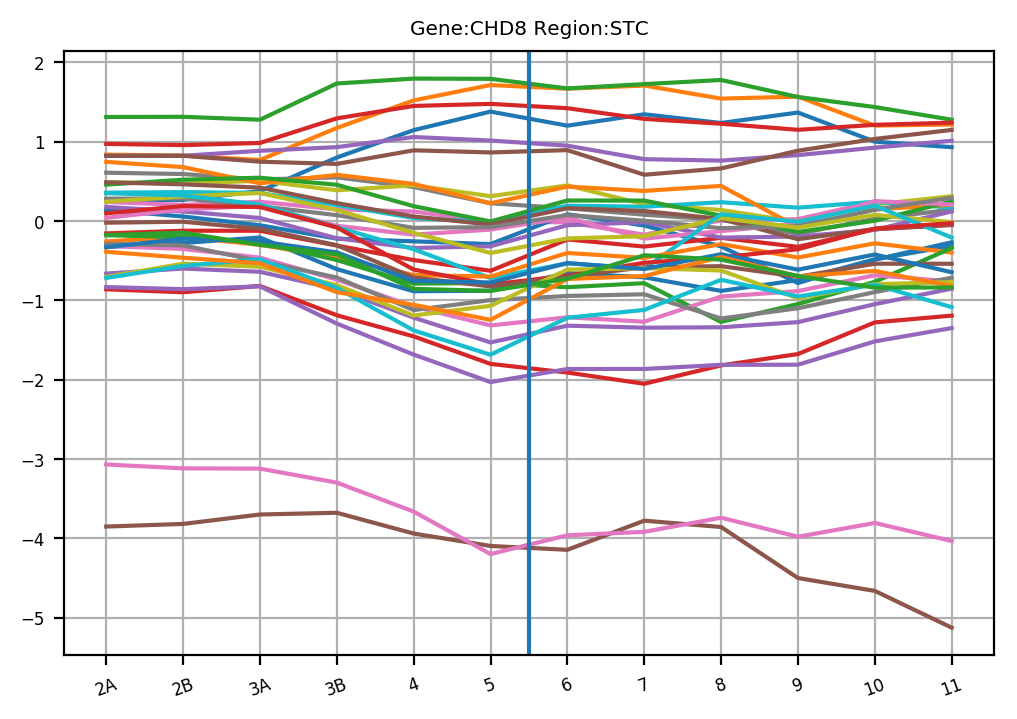

In [15]:
Look("CHD8", "STC", bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

plotting....

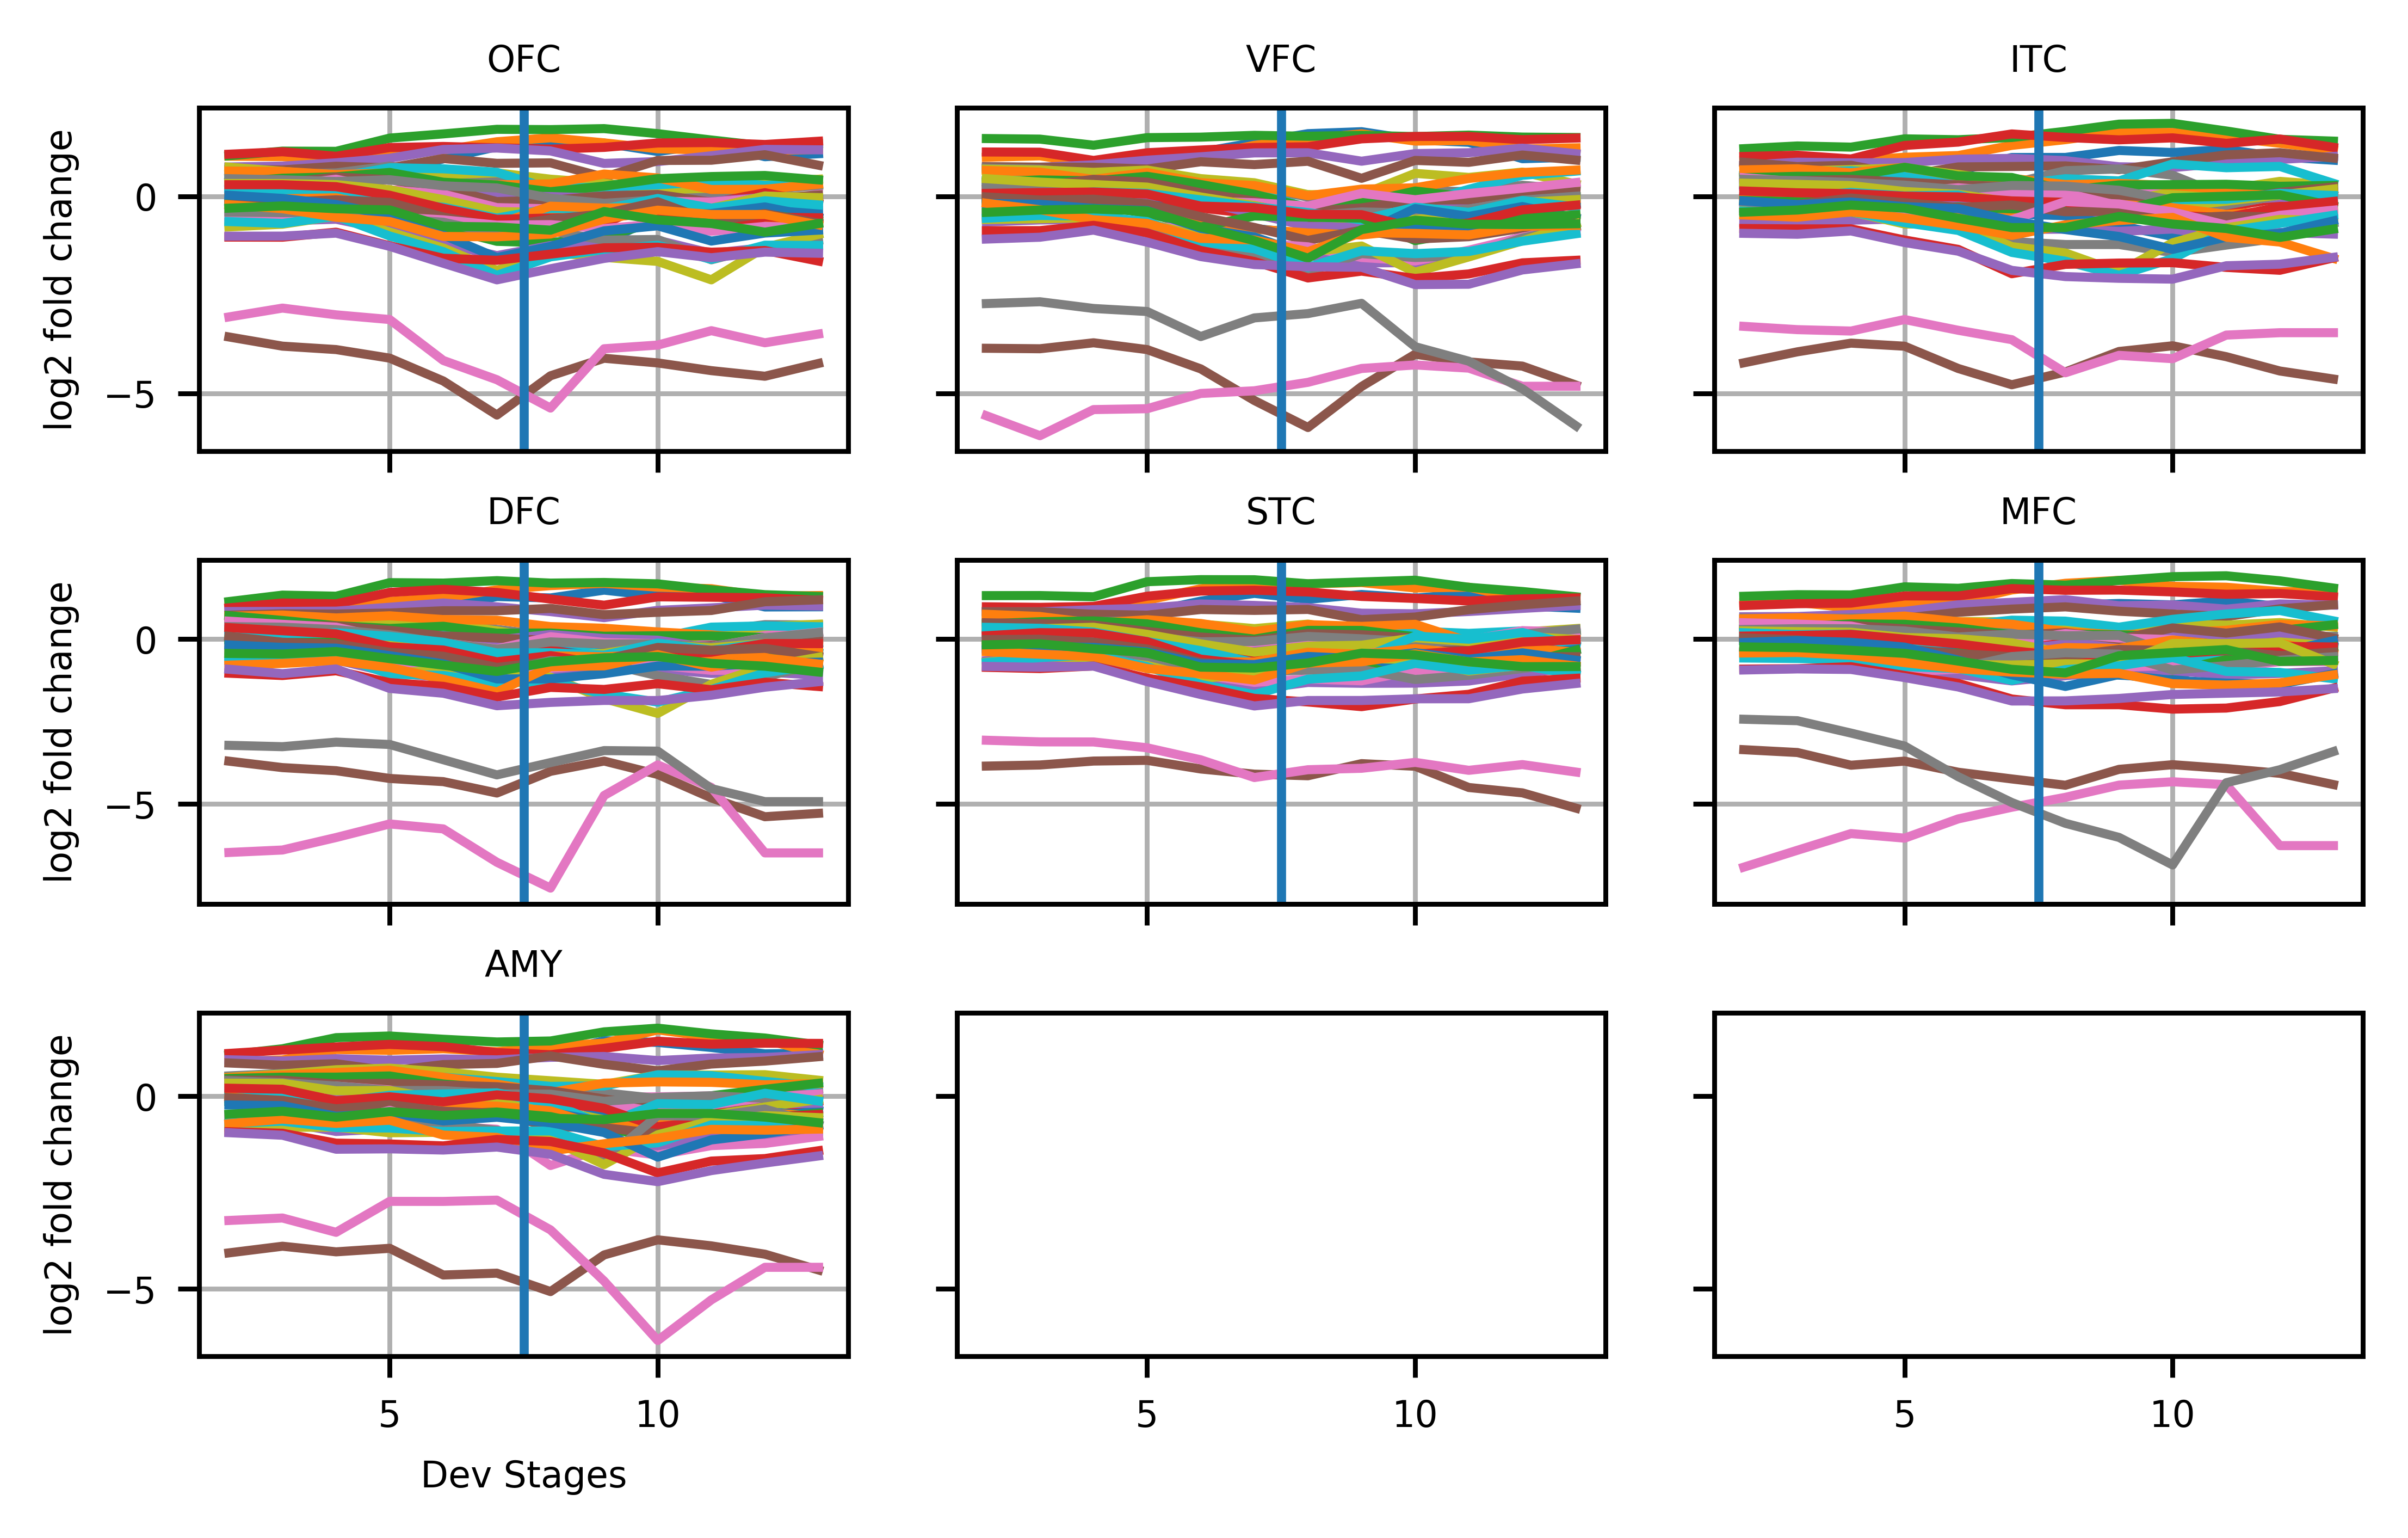

In [25]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC", "AMY"]
LookGrid("CHD8", Regions, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

16Three 0 data at stage 1
plotting....

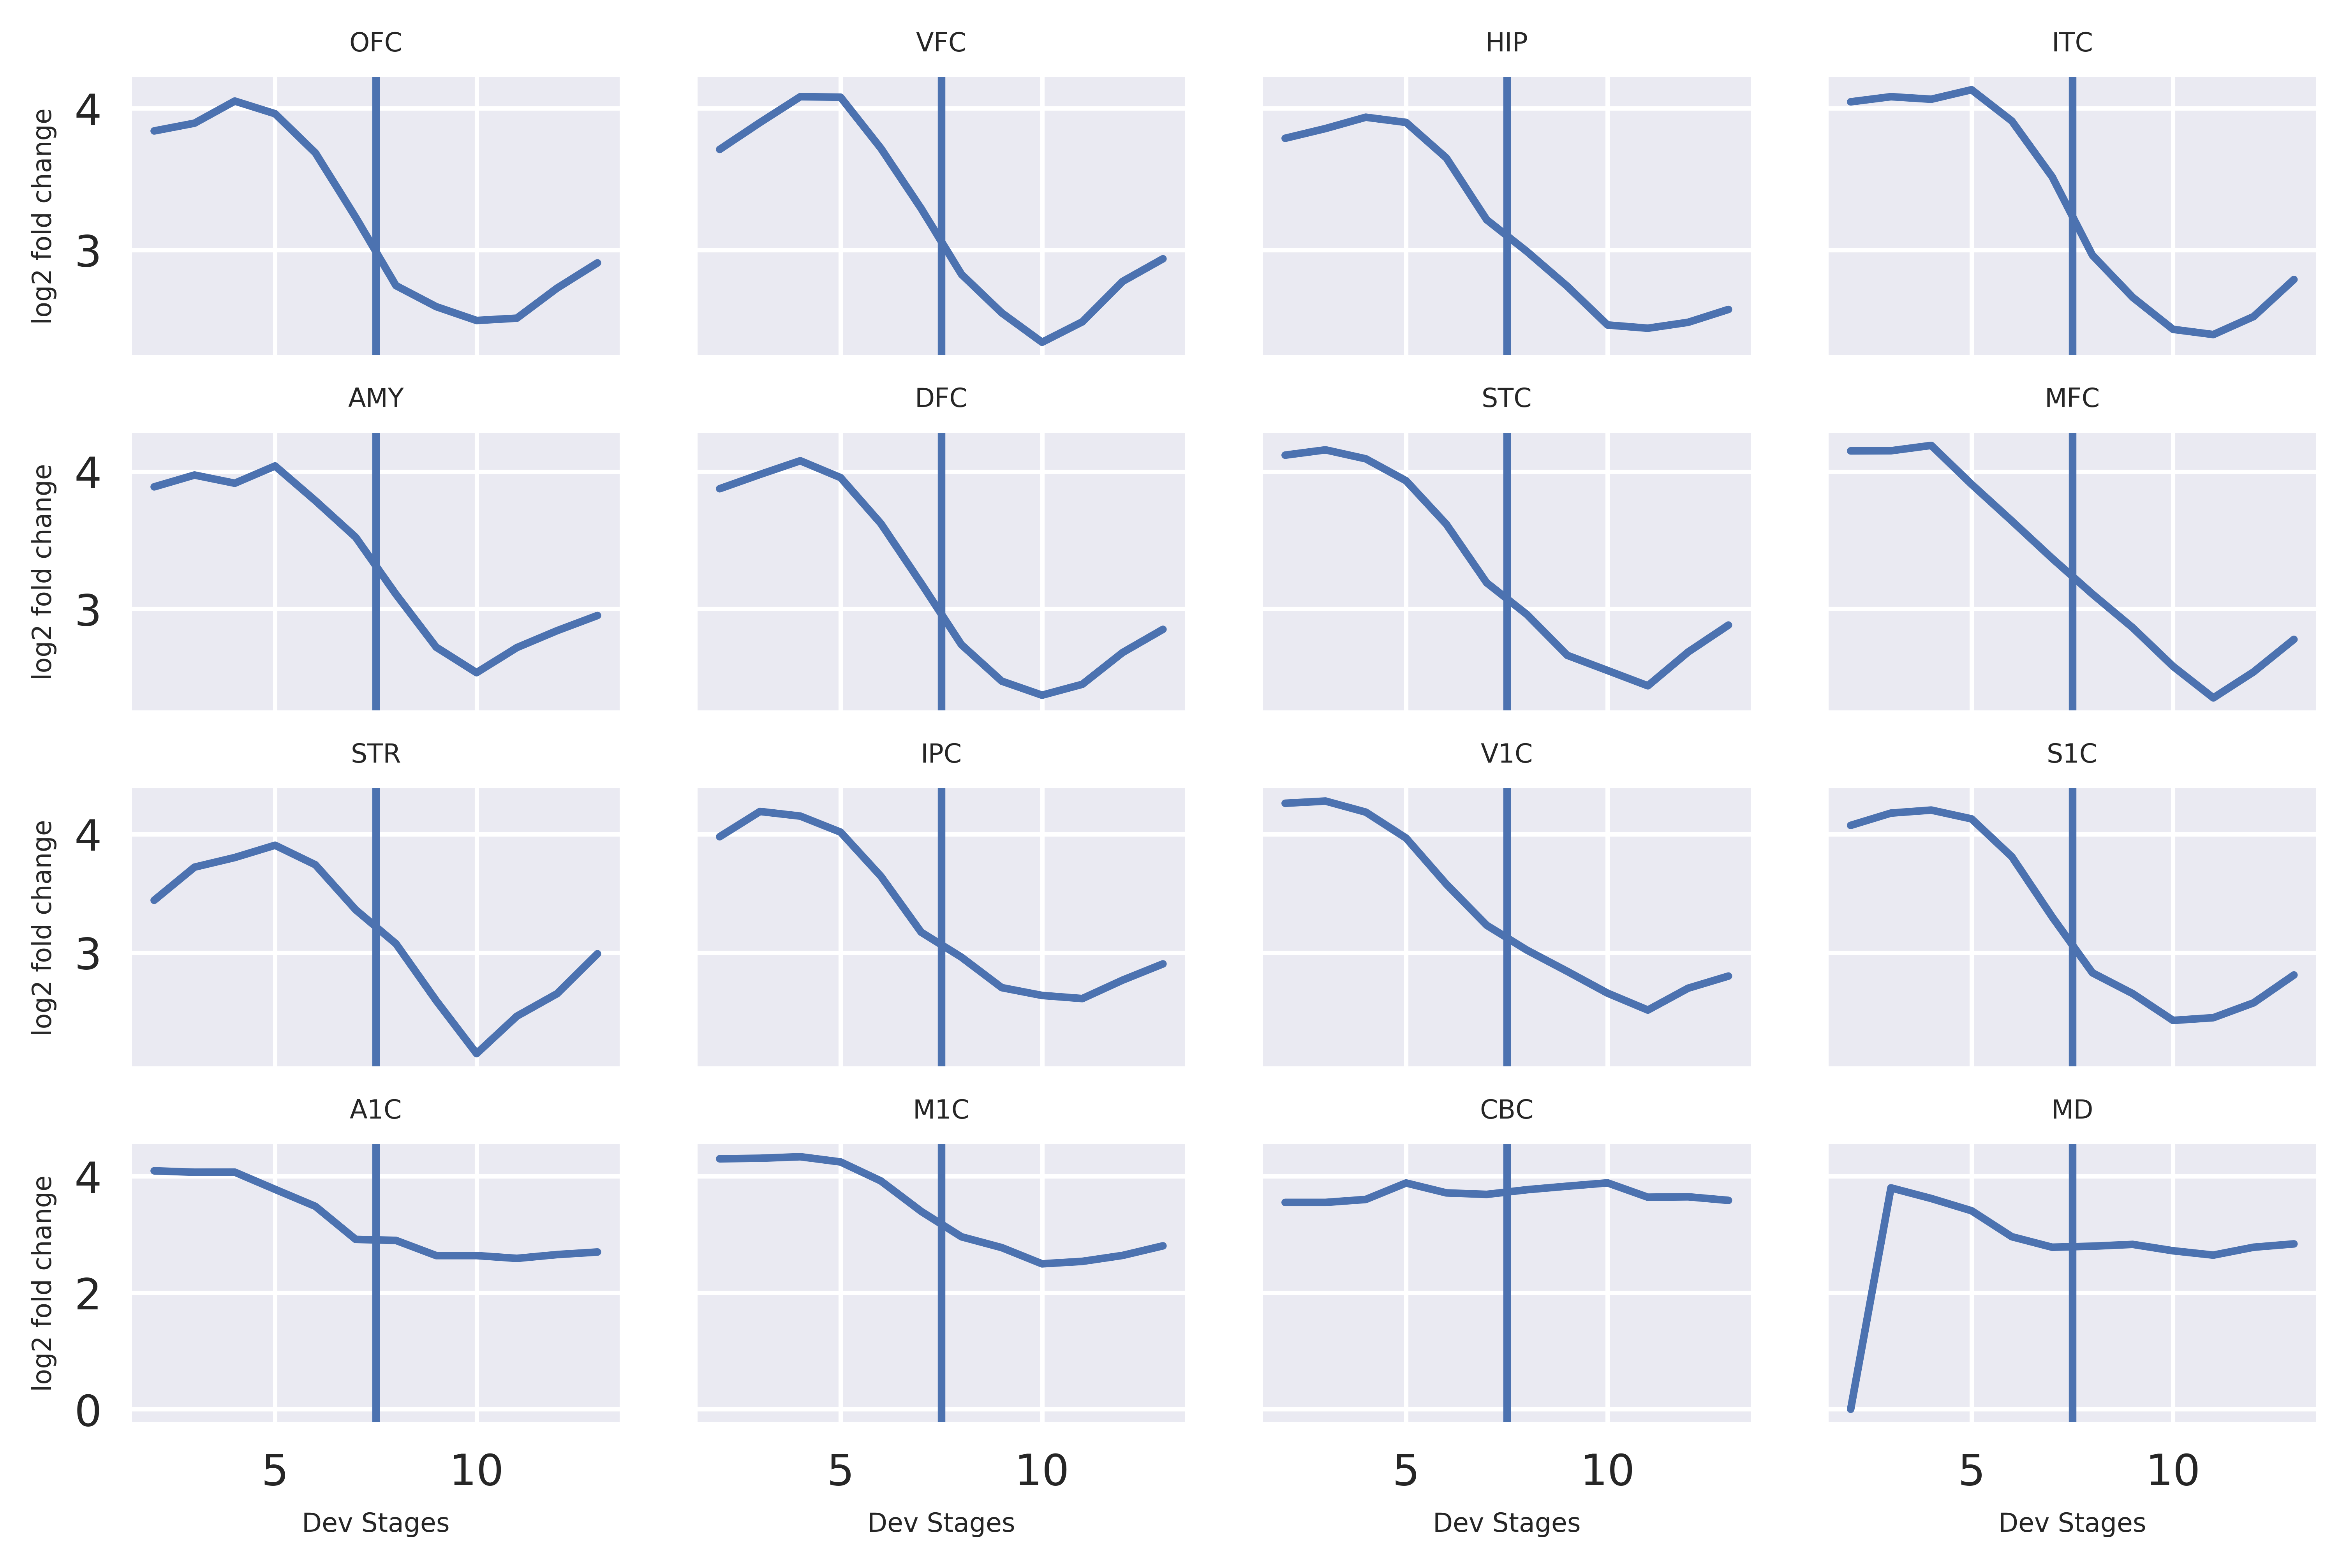

In [142]:
#Look2("DYRK1A", "OFC", GeneRow, GeneCol, GeneExp)
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC", "AMY"]
#Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGrid("CHD8", Regionsgt20, GeneRow, GeneCol, GeneExp, smooth=True)

16Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
Three 0 data at stage 1
plotting....

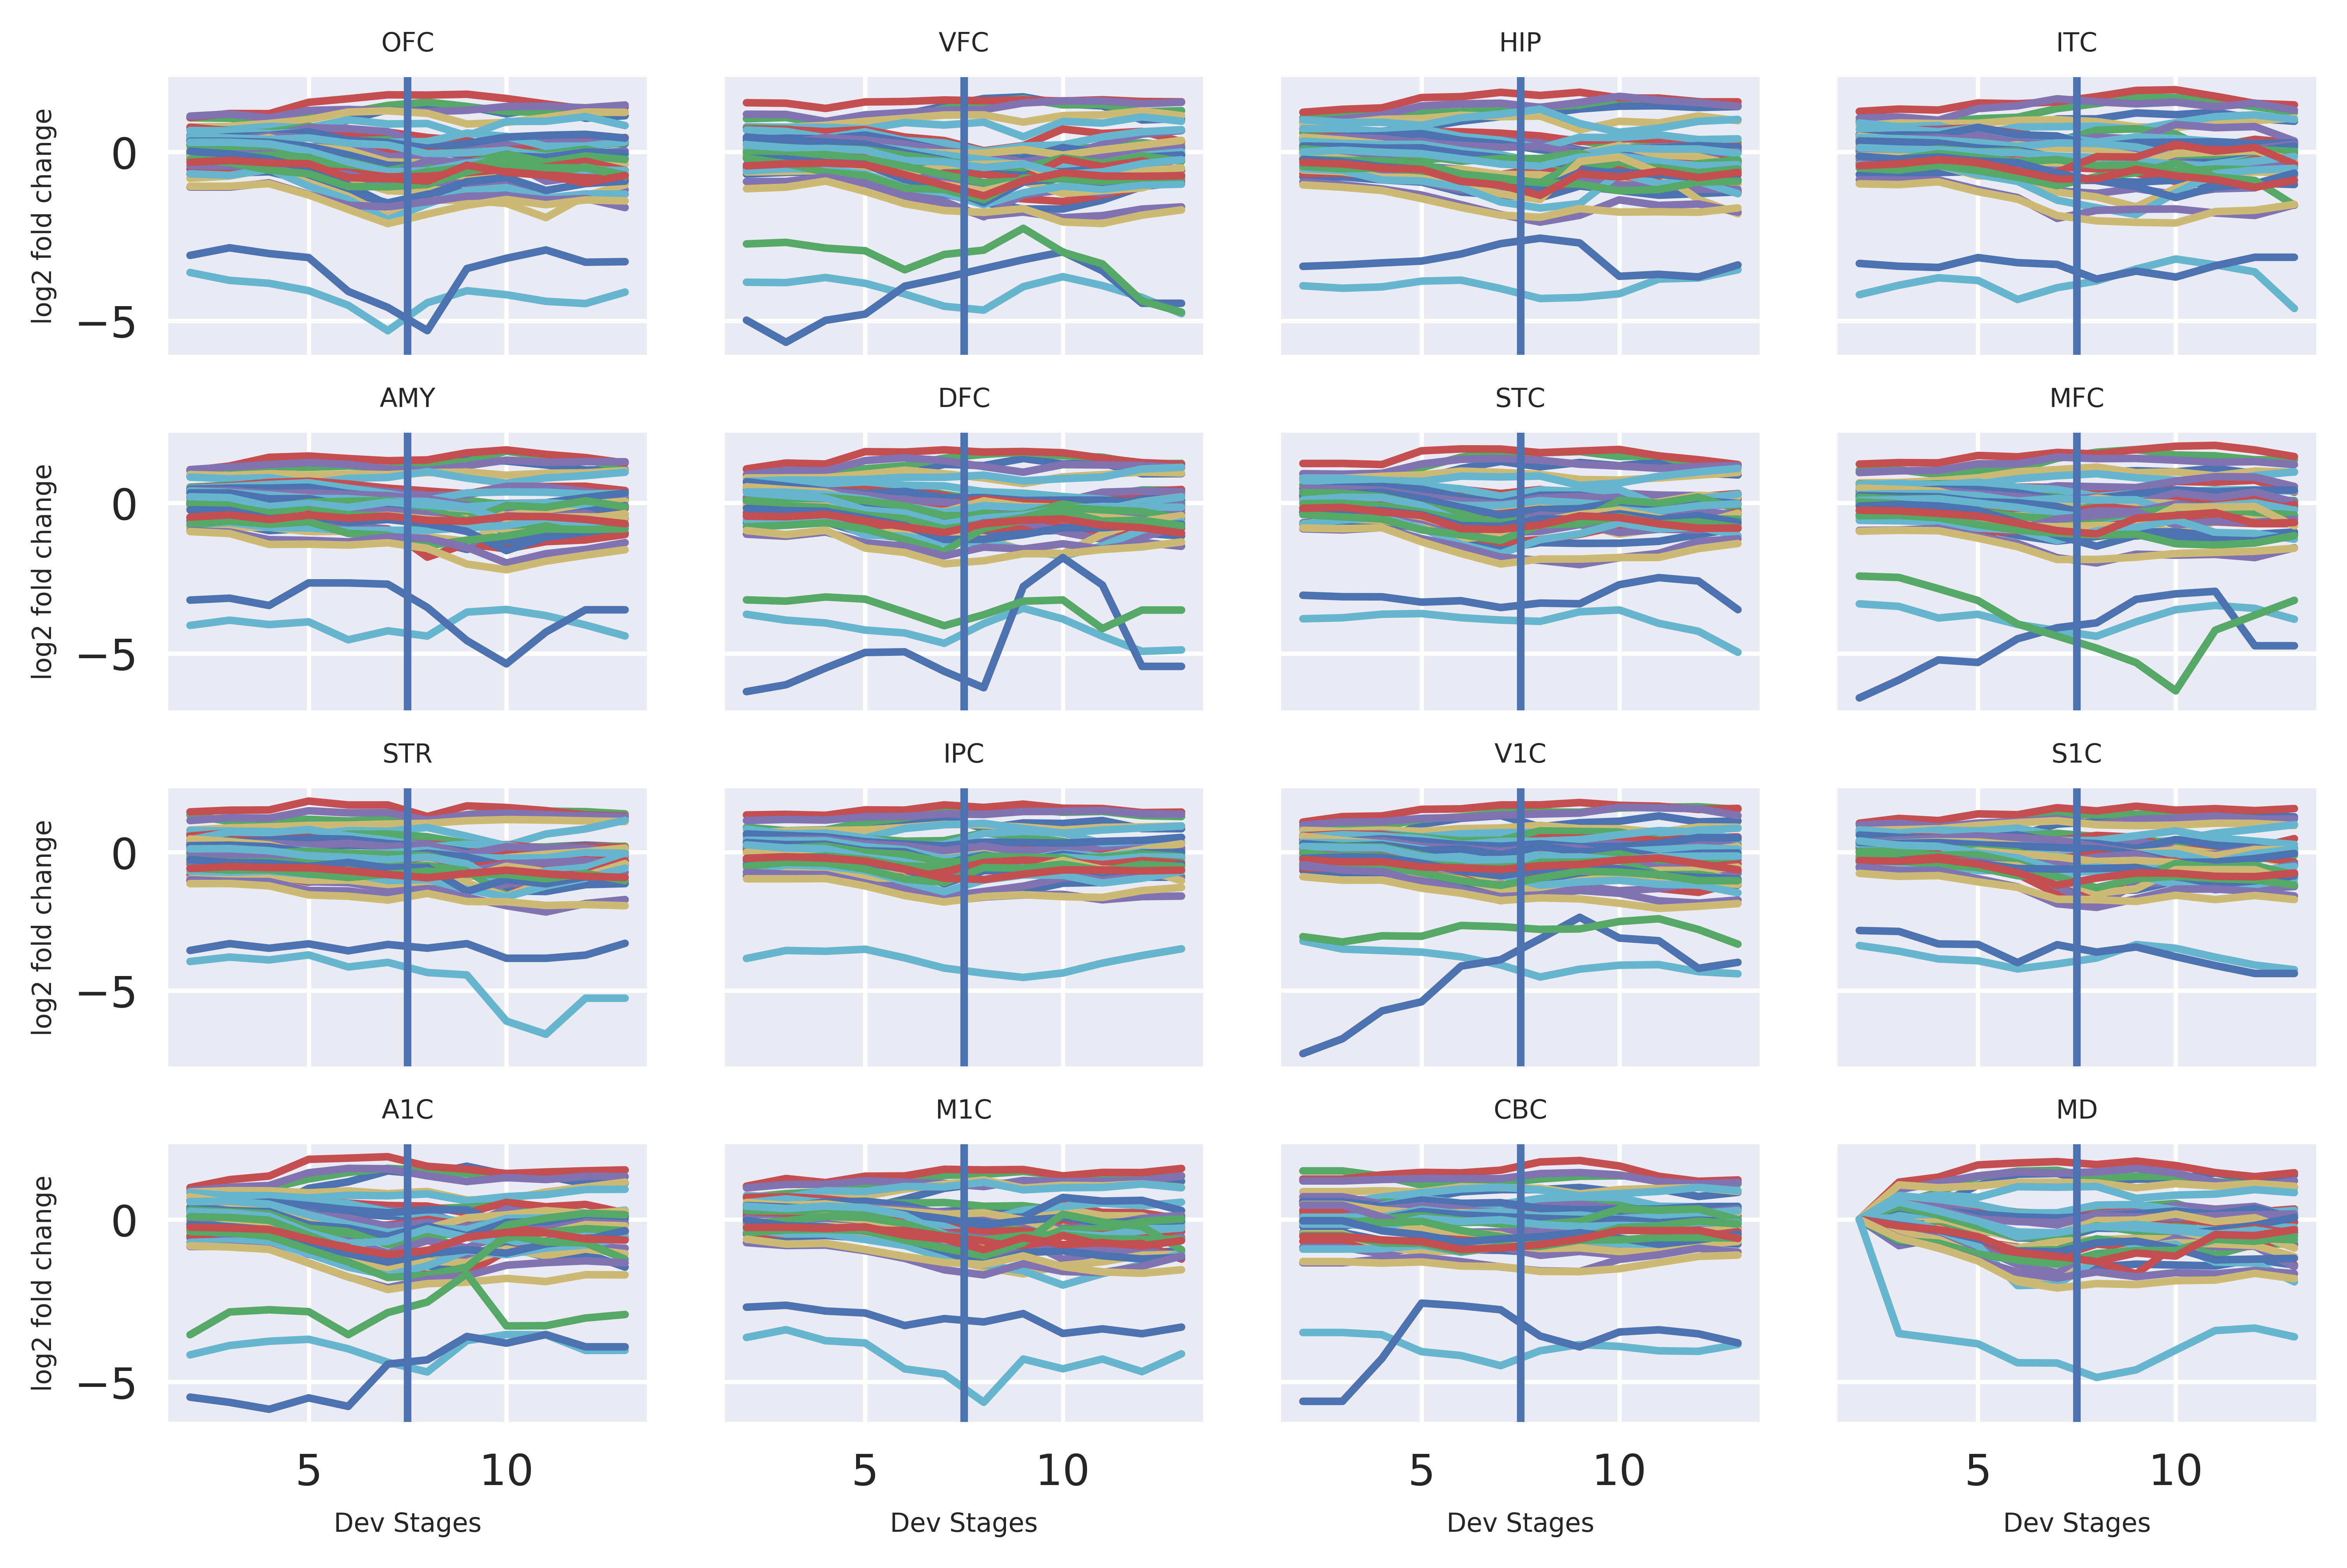

In [136]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGrid("CHD8", Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

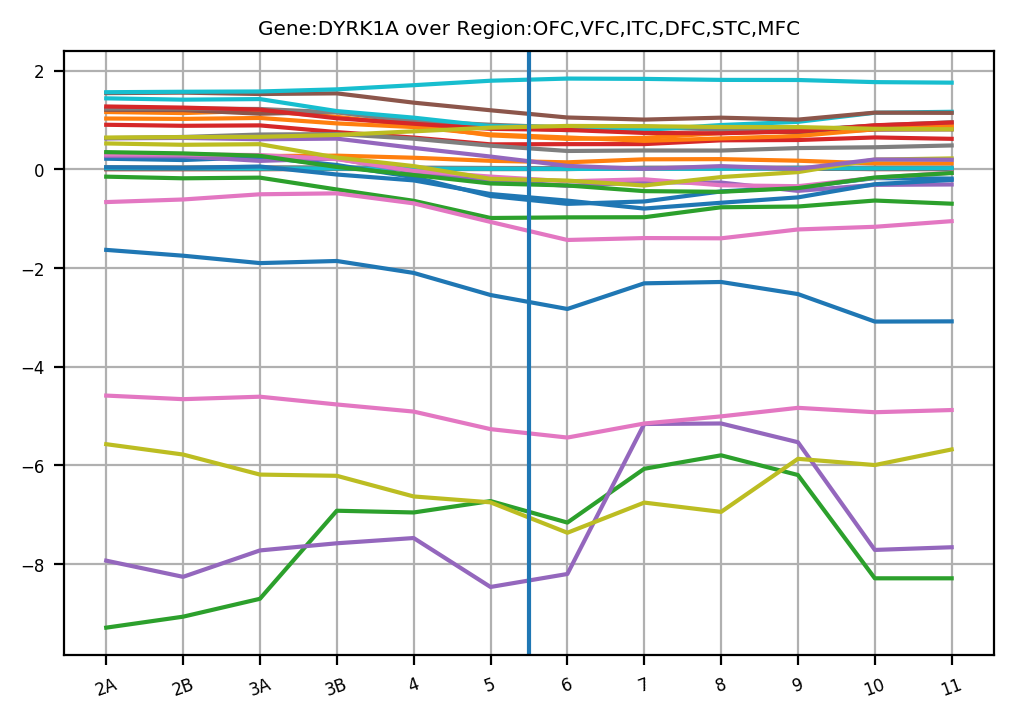

In [33]:
Regions = ["OFC", "VFC", "ITC", "DFC", "STC", "MFC"]
LookGridSumRegion("DYRK1A", Regions, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

In [351]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/Autism_LGD.csv"
AssignVar2Exon(bp_exon_row_meta, VarFile)
bp_exon_row_meta.head()

108264

KeyboardInterrupt: 

# Mutation targeted Exons

In [352]:
VarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014LGD.xlsx"
AssignVar2Exon2(bp_exon_row_meta, VarFile)

309222

In [355]:
bp_exon_row_meta_with_gene = bp_exon_row_meta[bp_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_with_gene.to_excel("GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]!=""]
bp_exon_row_meta_without_var = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["Vars"]==""]
print bp_exon_row_meta_with_gene.shape, bp_exon_row_meta_with_var.shape, bp_exon_row_meta_without_var.shape

(2269, 15) (107, 15) (2162, 15)


Loading records:106
Loading records:2161


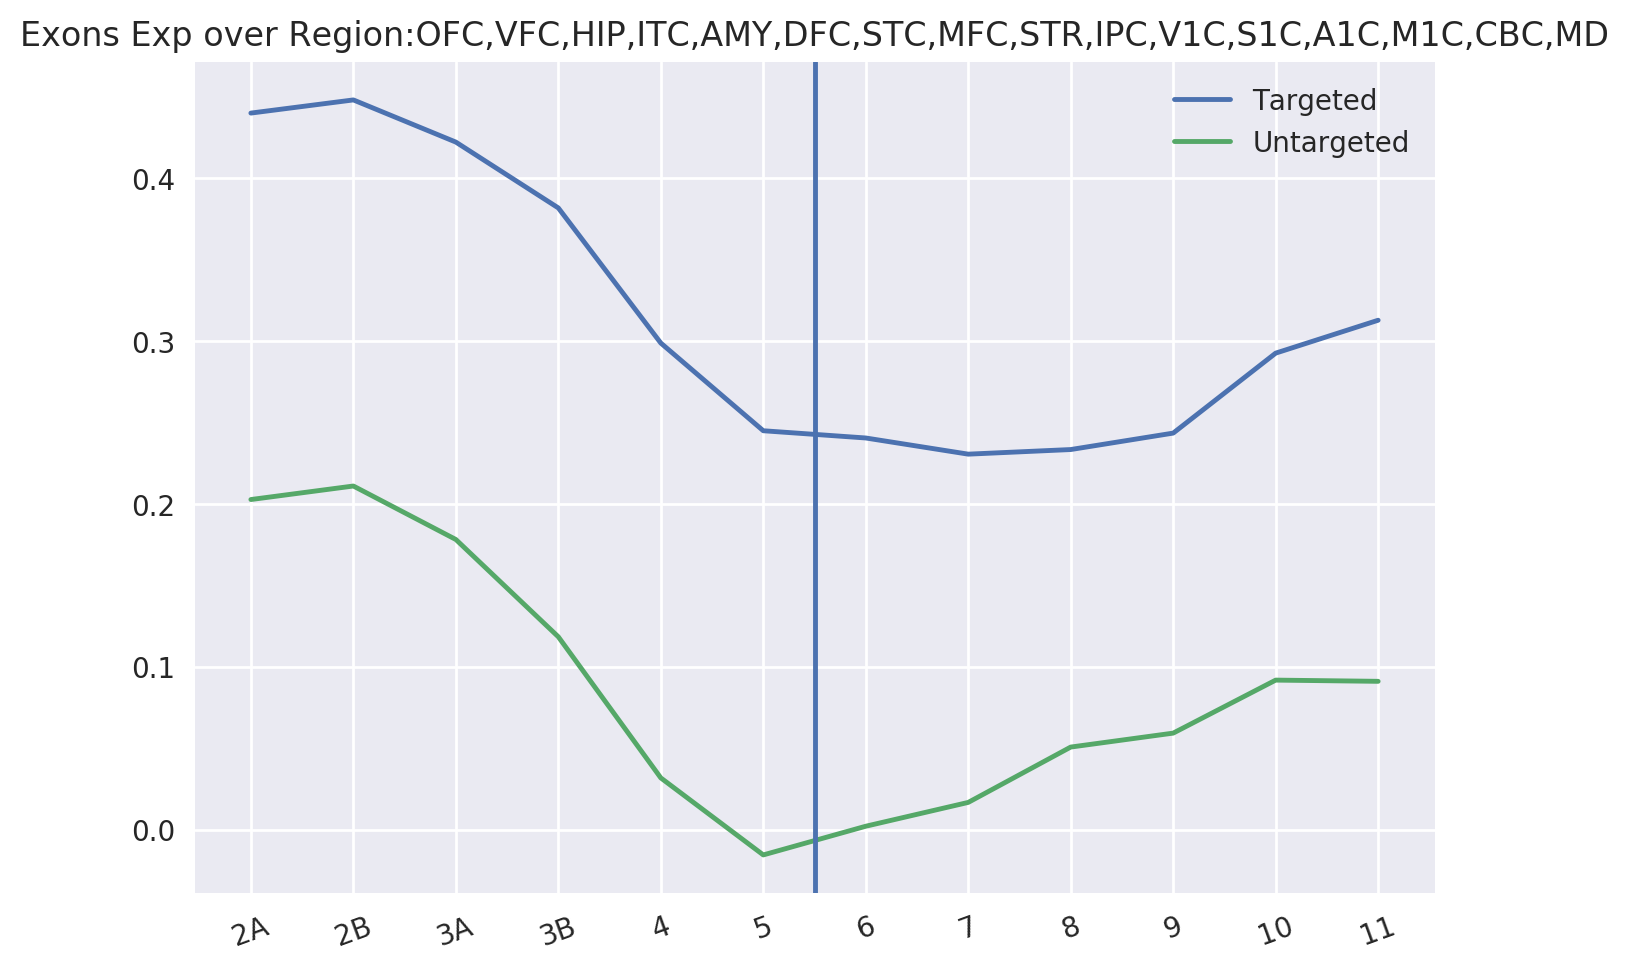

In [327]:
selected_exons = list(bp_exon_row_meta_with_var["row_num"])
Notselected_exons = list(bp_exon_row_meta_without_var["row_num"])
Select_UnSelect = dict(zip(["Targeted", "Untargeted"],[selected_exons, Notselected_exons]))
lengths = LookALLMutationTargetedExon2(Select_UnSelect, Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp)

### Exon Length / Pos Anly

small
Loading records:75
large
Loading records:30
large_nonlast
Loading records:26
last
Loading records:5


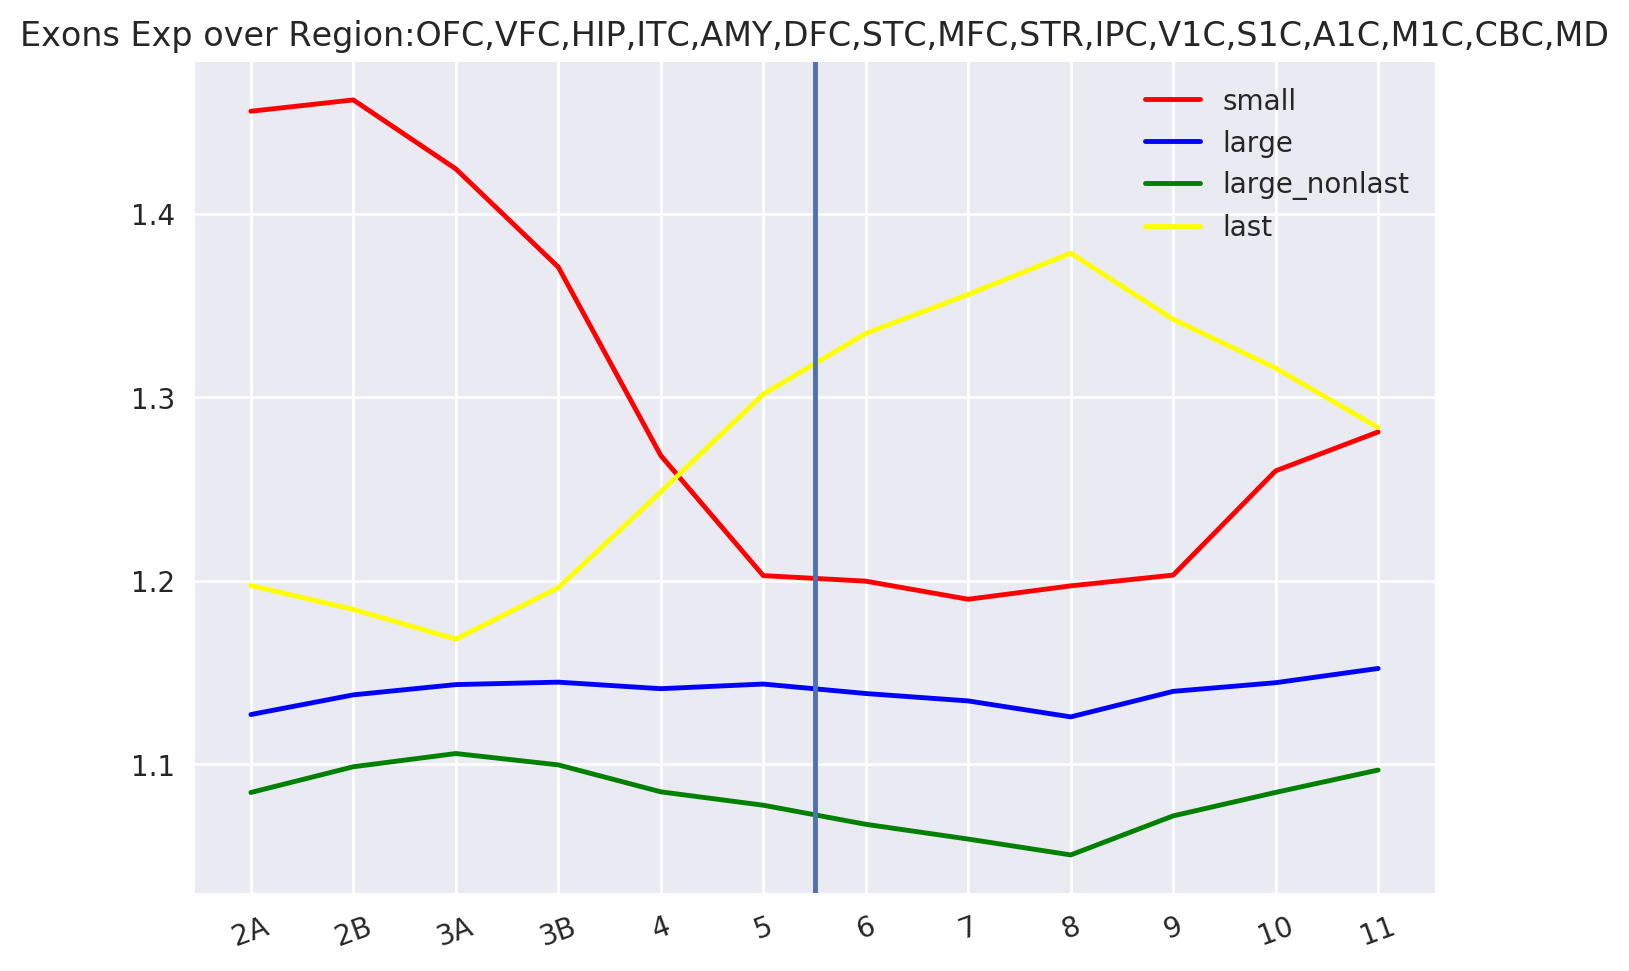

small
Loading records:75
large
Loading records:30
large_nonlast
Loading records:26
last
Loading records:5


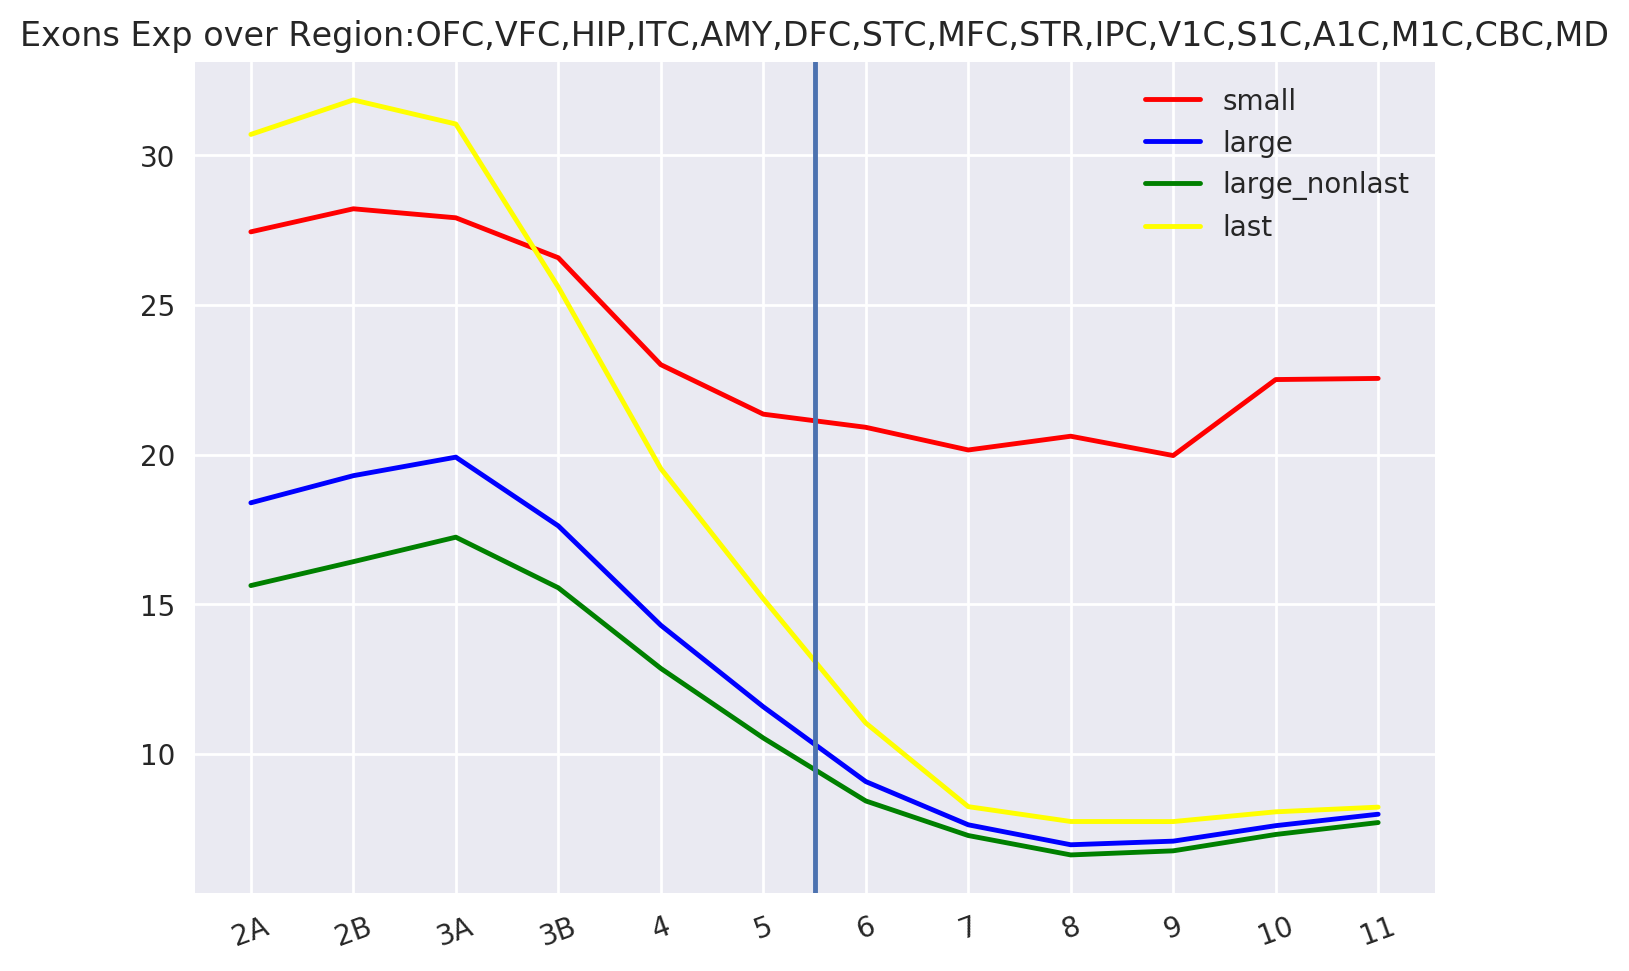

In [368]:
small_exons = ('red', list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var
                                             ["exon length"]<1000]["row_num"]))
large_exons = ('blue', list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var
                                             ["exon length"]>1000]["row_num"]))
large_nonlast_exons = ('green', list(bp_exon_row_meta_with_var[ (bp_exon_row_meta_with_var
            ["exon length"]>1000) & (bp_exon_row_meta_with_var["Last"]=="F") ]["row_num"]))
large_last_exons = ('yellow', list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var
                                                  ["Last"]=="T"]["row_num"]))
Size = dict(zip(["small", "large", "large_nonlast", "last"],
              [small_exons, large_exons, large_nonlast_exons, large_last_exons]))
LookALLMutationTargetedExon2(Size, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)
LookALLMutationTargetedExon2(Size, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, ExonExp)

Targeted
Loading records:106
Untargeted
Loading records:2161


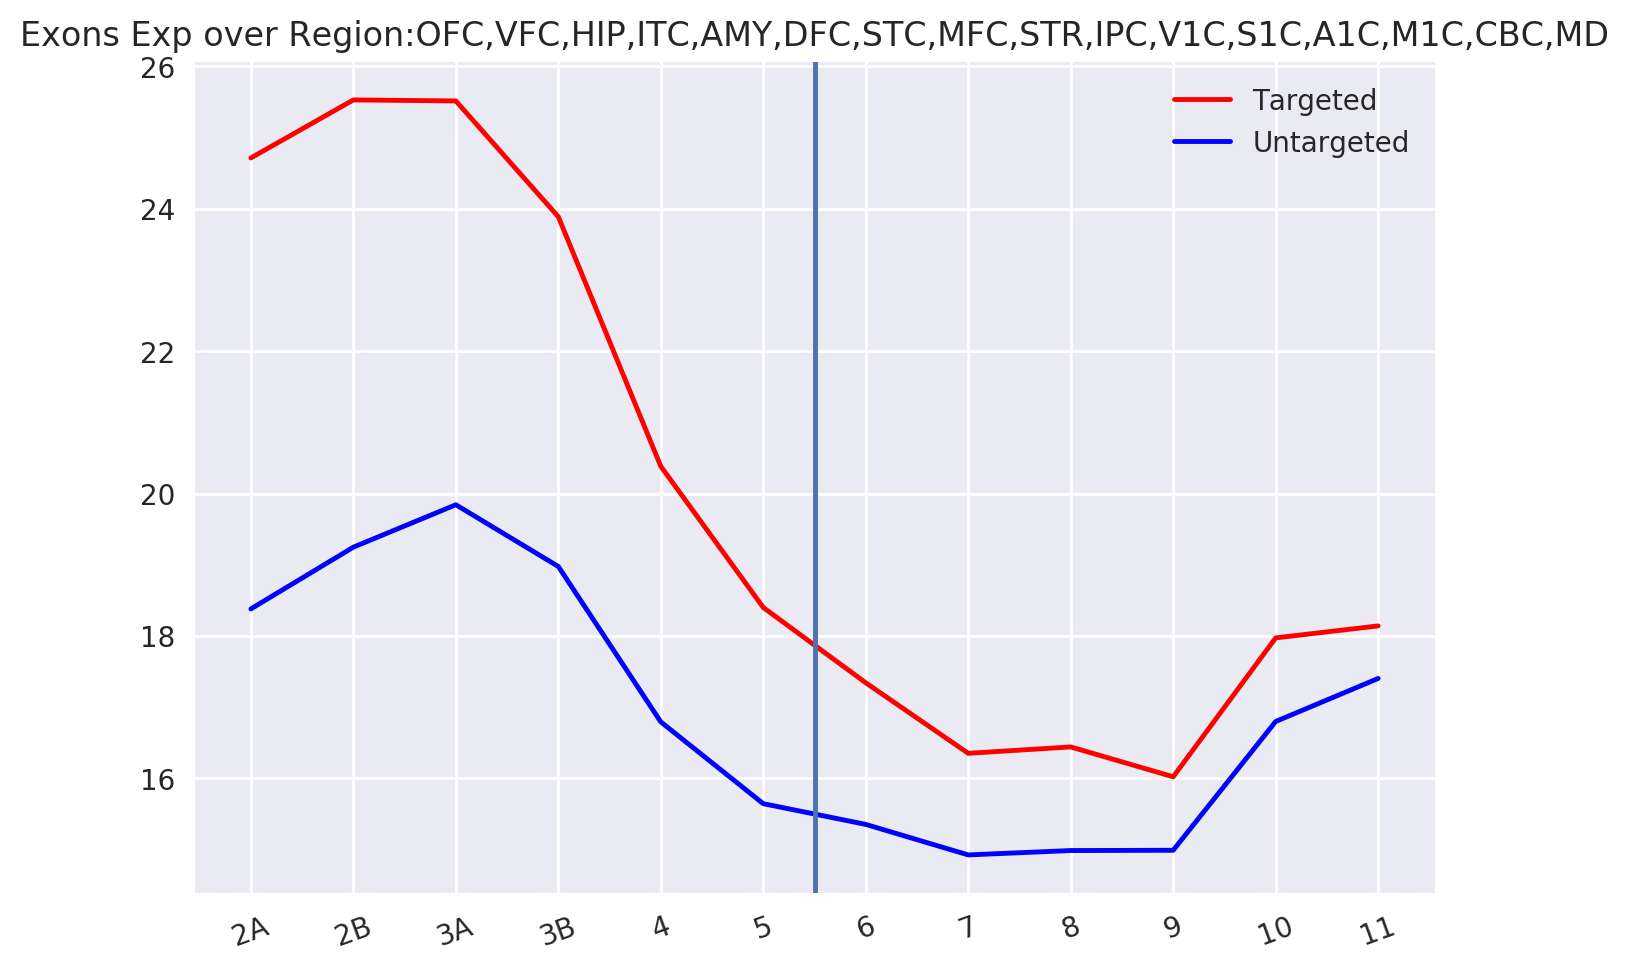

In [350]:
selected_exons = ('red', list(bp_exon_row_meta_with_var["row_num"]))
Notselected_exons = ('blue', list(bp_exon_row_meta_without_var["row_num"]))
Select_UnSelect = dict(zip(["Targeted", "Untargeted"],[selected_exons, Notselected_exons]))
lengths = LookALLMutationTargetedExon2(Select_UnSelect, Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, ExonExp)

Male
Loading records:80
Female
Loading records:27


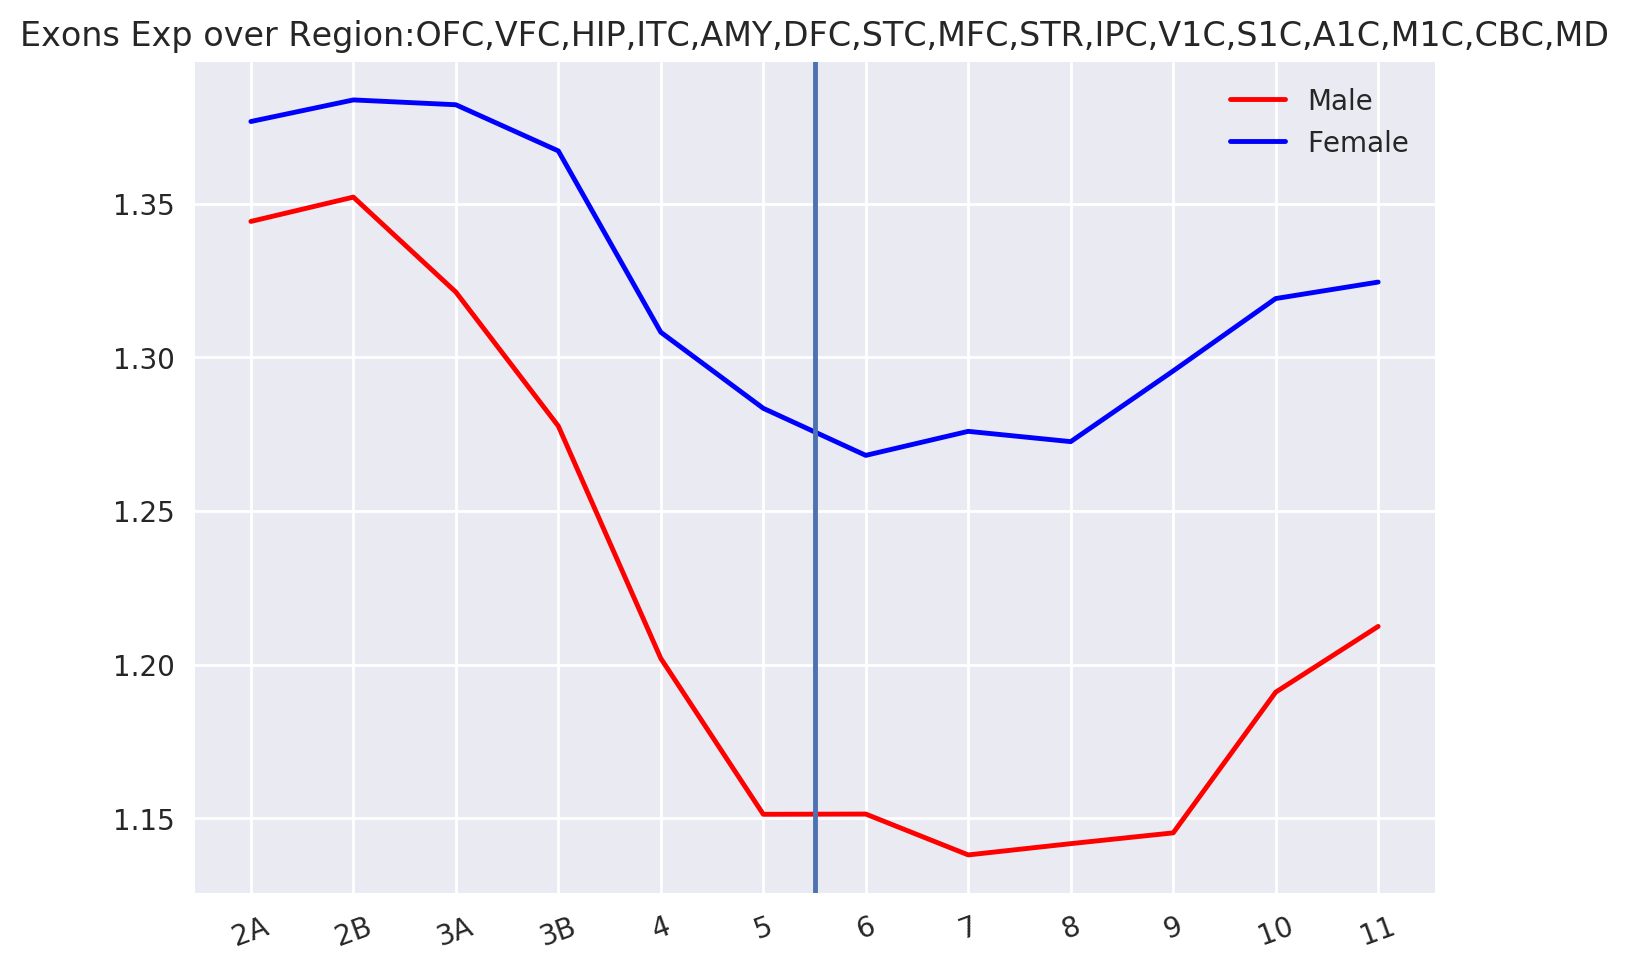

Male
Loading records:80
Female
Loading records:27


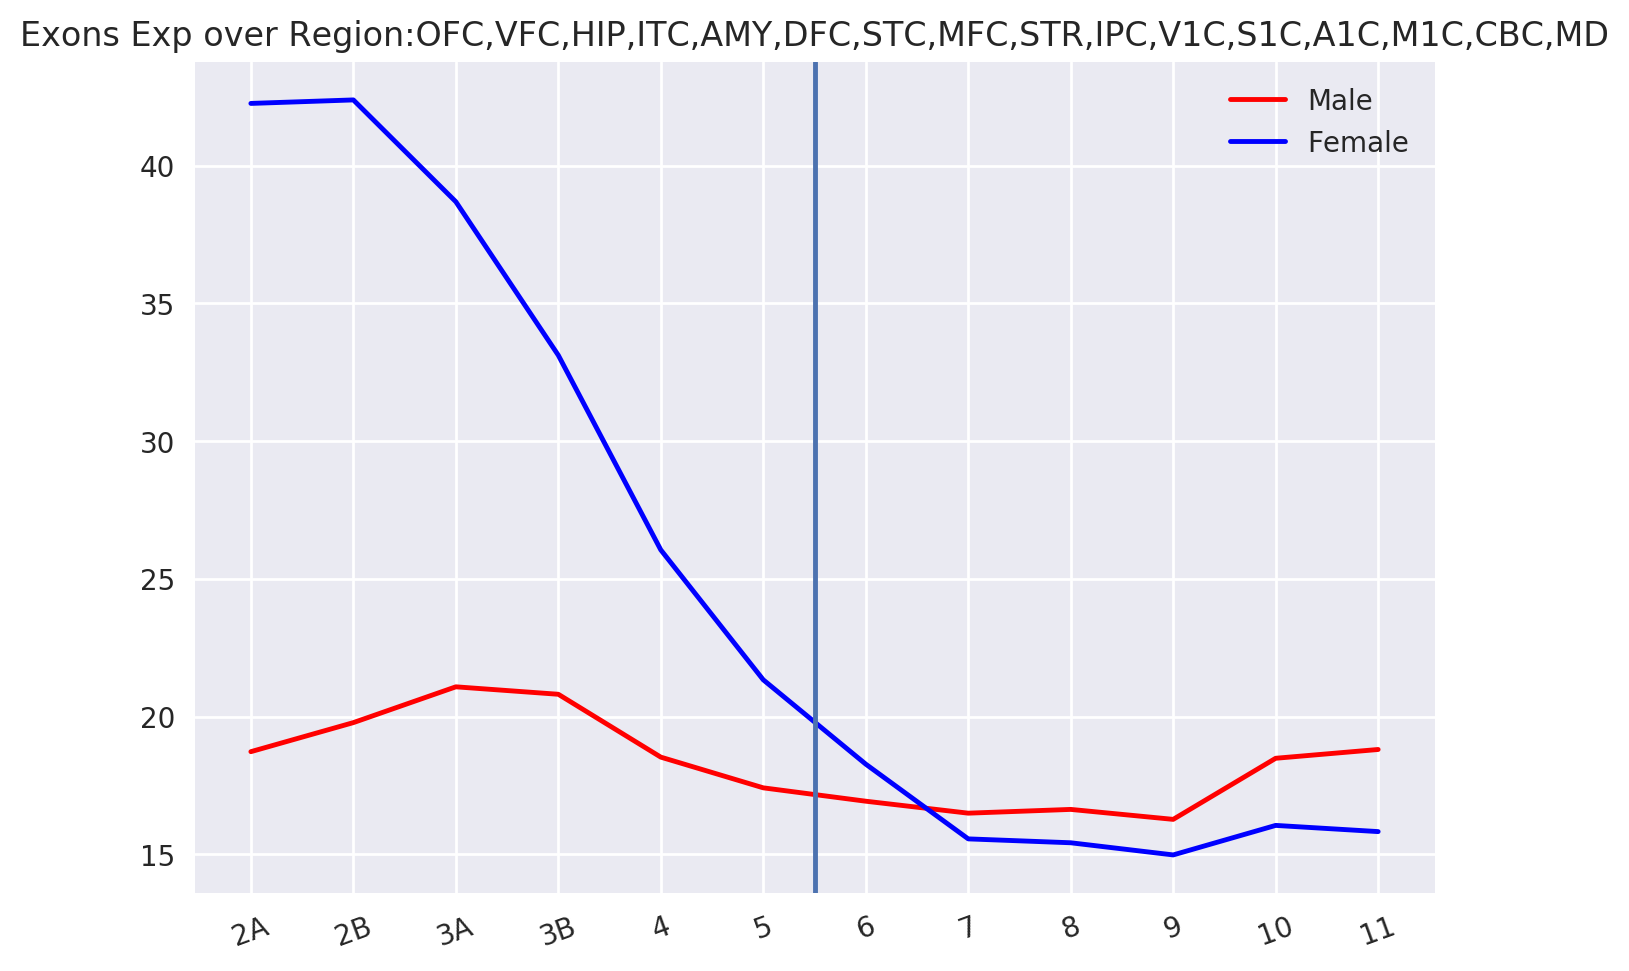

In [366]:
Male_exons = ("red", list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["Gender"].isin(["pM", "pM;pM","pM;pF"])]["row_num"]))
FeMale_exons = ("blue", list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["Gender"].isin(["pF","pM;pF"])]["row_num"]))
Male_FeMale = dict(zip(["Male", "Female"],[Male_exons, FeMale_exons]))
LookALLMutationTargetedExon2(Male_FeMale, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)
LookALLMutationTargetedExon2(Male_FeMale, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, ExonExp)

In [ ]:
MaleGene_untargeted_exon = 
FemaleGene_untargeted_exon = 

psd_Target_exon
Loading records:1
chromatin_Target_exon
Loading records:11
channel_Other_exon
Loading records:36
channel_Target_exon
Loading records:3
sig_skel_Other_exon
Loading records:70
psd_Other_exon
Loading records:81
sig_skel_Target_exon
Loading records:3
chromatin_Other_exon
Loading records:151


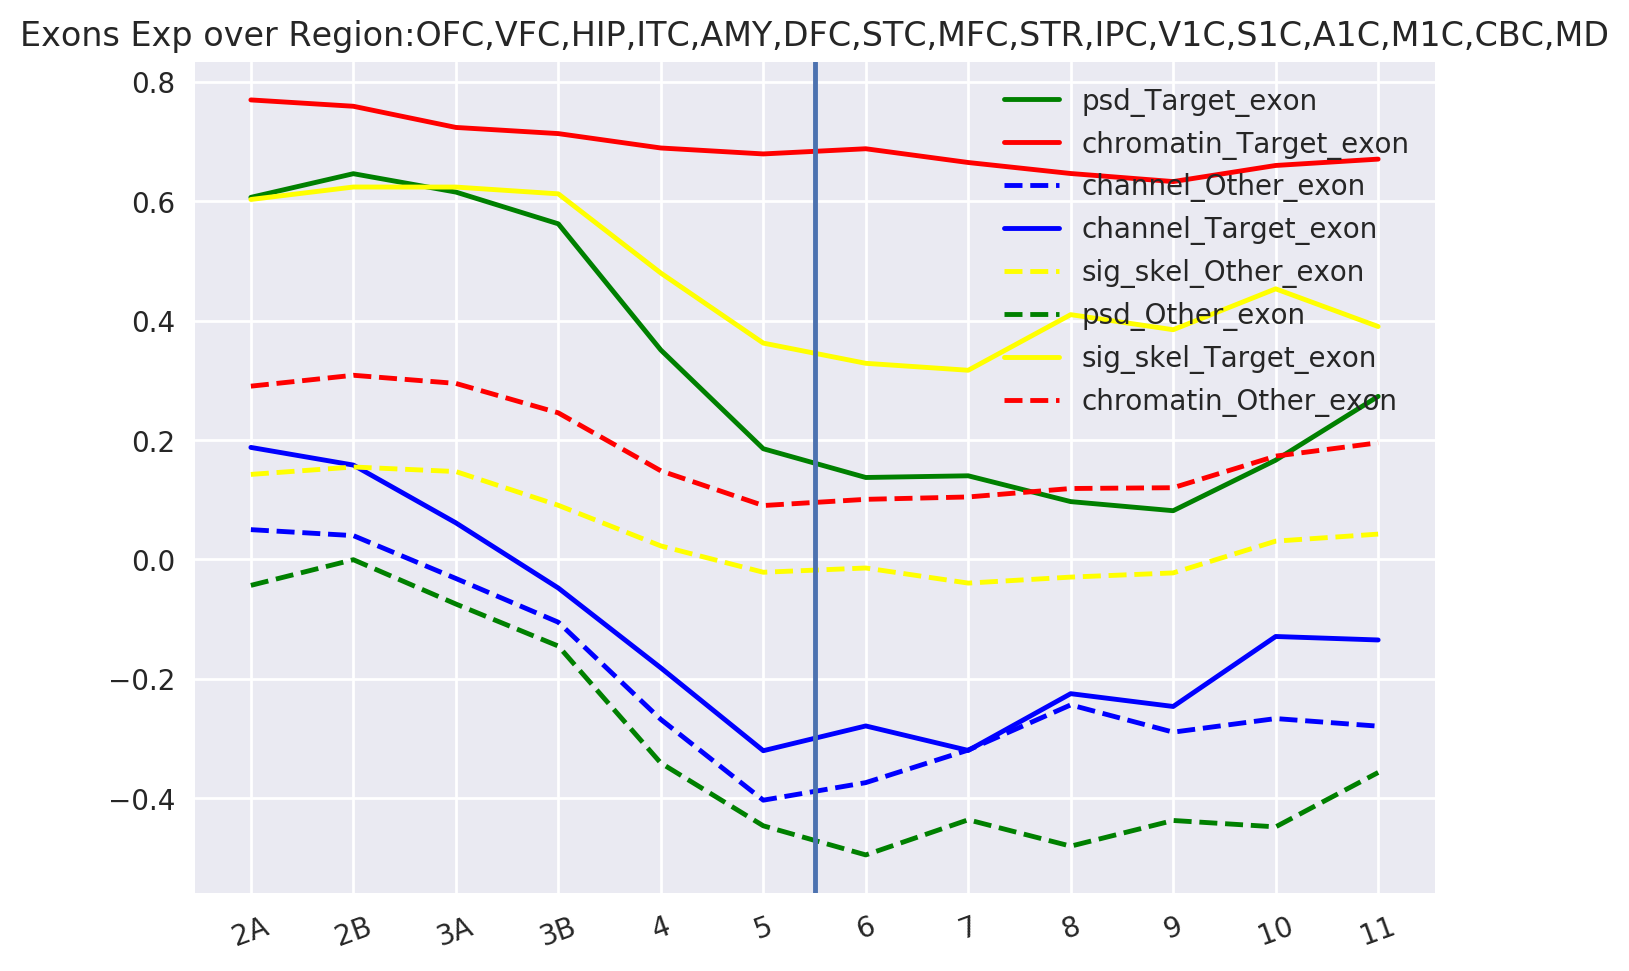

In [348]:
cates = {}
color=["red", "blue", "yellow", "green"]
for i,func in enumerate(["chromatin", "channel", "sig_skel", "psd"]):
    cates[func+"_Target_exon"] = (color[i], 
                    list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["Func"]==func]["row_num"]))
    cates[func+"_Other_exon"] = (color[i], 
                    list(bp_exon_row_meta_without_var[bp_exon_row_meta_without_var["Func"]==func]["row_num"]))
LookALLMutationTargetedExon2(cates, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

psd_Target_exon
Loading records:1
chromatin_Target_exon
Loading records:11
channel_Other_exon
Loading records:36
channel_Target_exon
Loading records:3
sig_skel_Other_exon
Loading records:70
psd_Other_exon
Loading records:81
sig_skel_Target_exon
Loading records:3
chromatin_Other_exon
Loading records:151


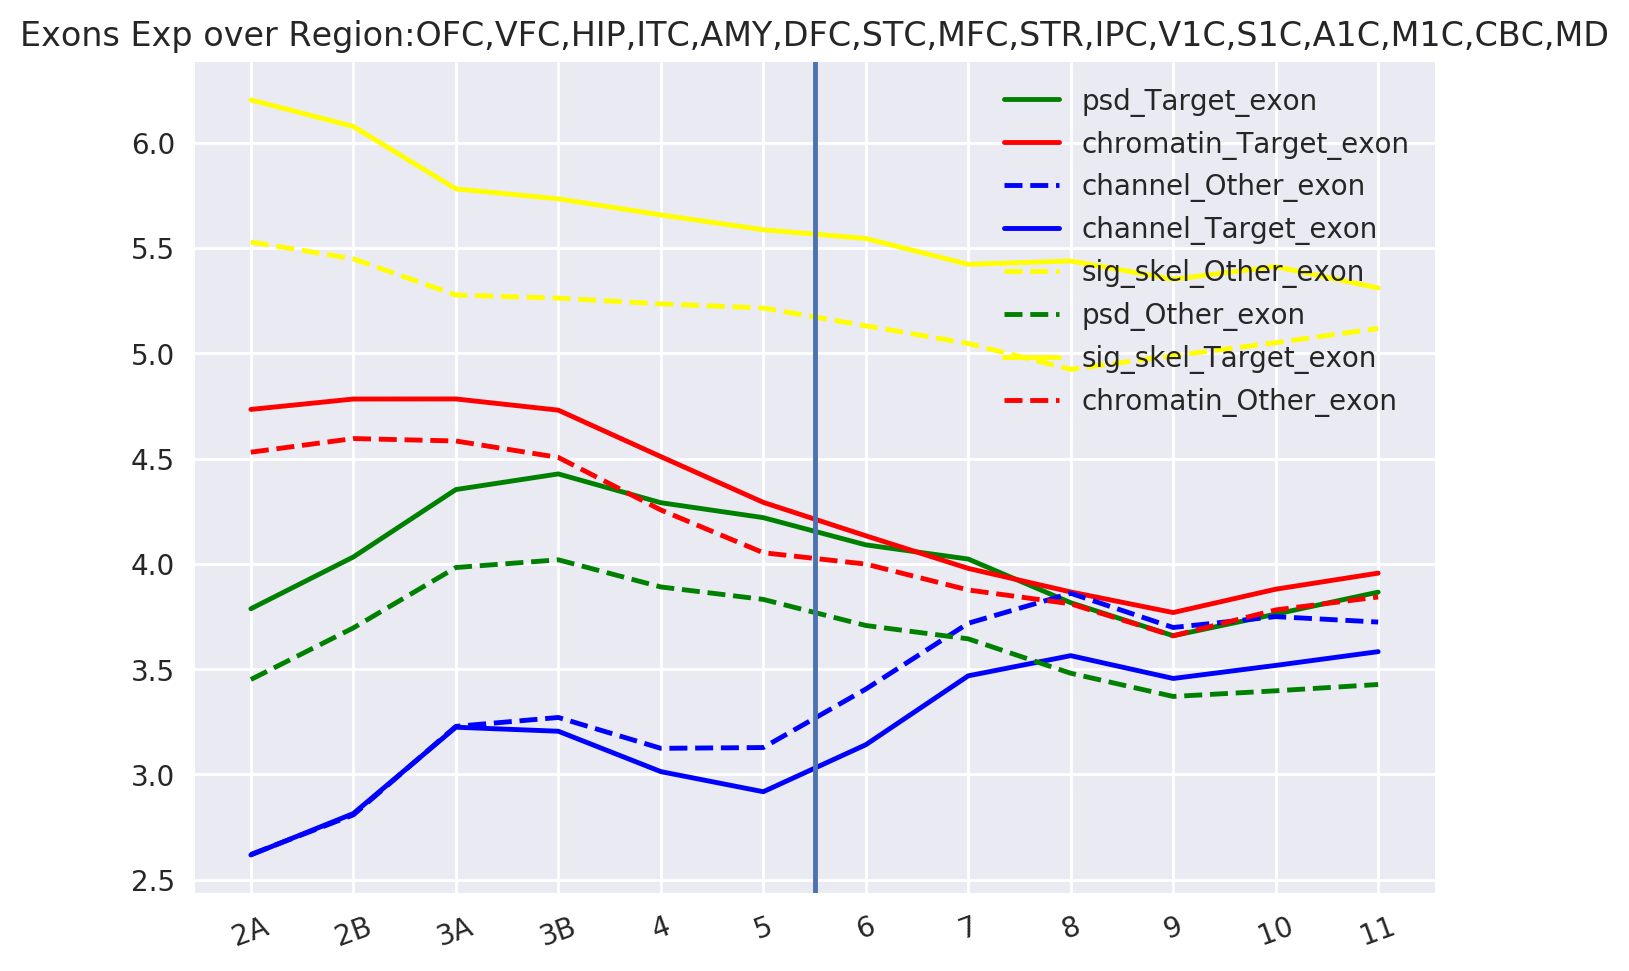

In [347]:
cates = {}
color=["red", "blue", "yellow", "green"]
for i,func in enumerate(["chromatin", "channel", "sig_skel", "psd"]):
    cates[func+"_Target_exon"] = (color[i], 
                    list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["Func"]==func]["row_num"]))
    cates[func+"_Other_exon"] = (color[i], 
                    list(bp_exon_row_meta_without_var[bp_exon_row_meta_without_var["Func"]==func]["row_num"]))
LookALLMutationTargetedExon2(cates, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, ExonExp)

LVIQ
Loading records:39
HNVIQ
Loading records:59
HVIQ
Loading records:61
LNVIQ
Loading records:46


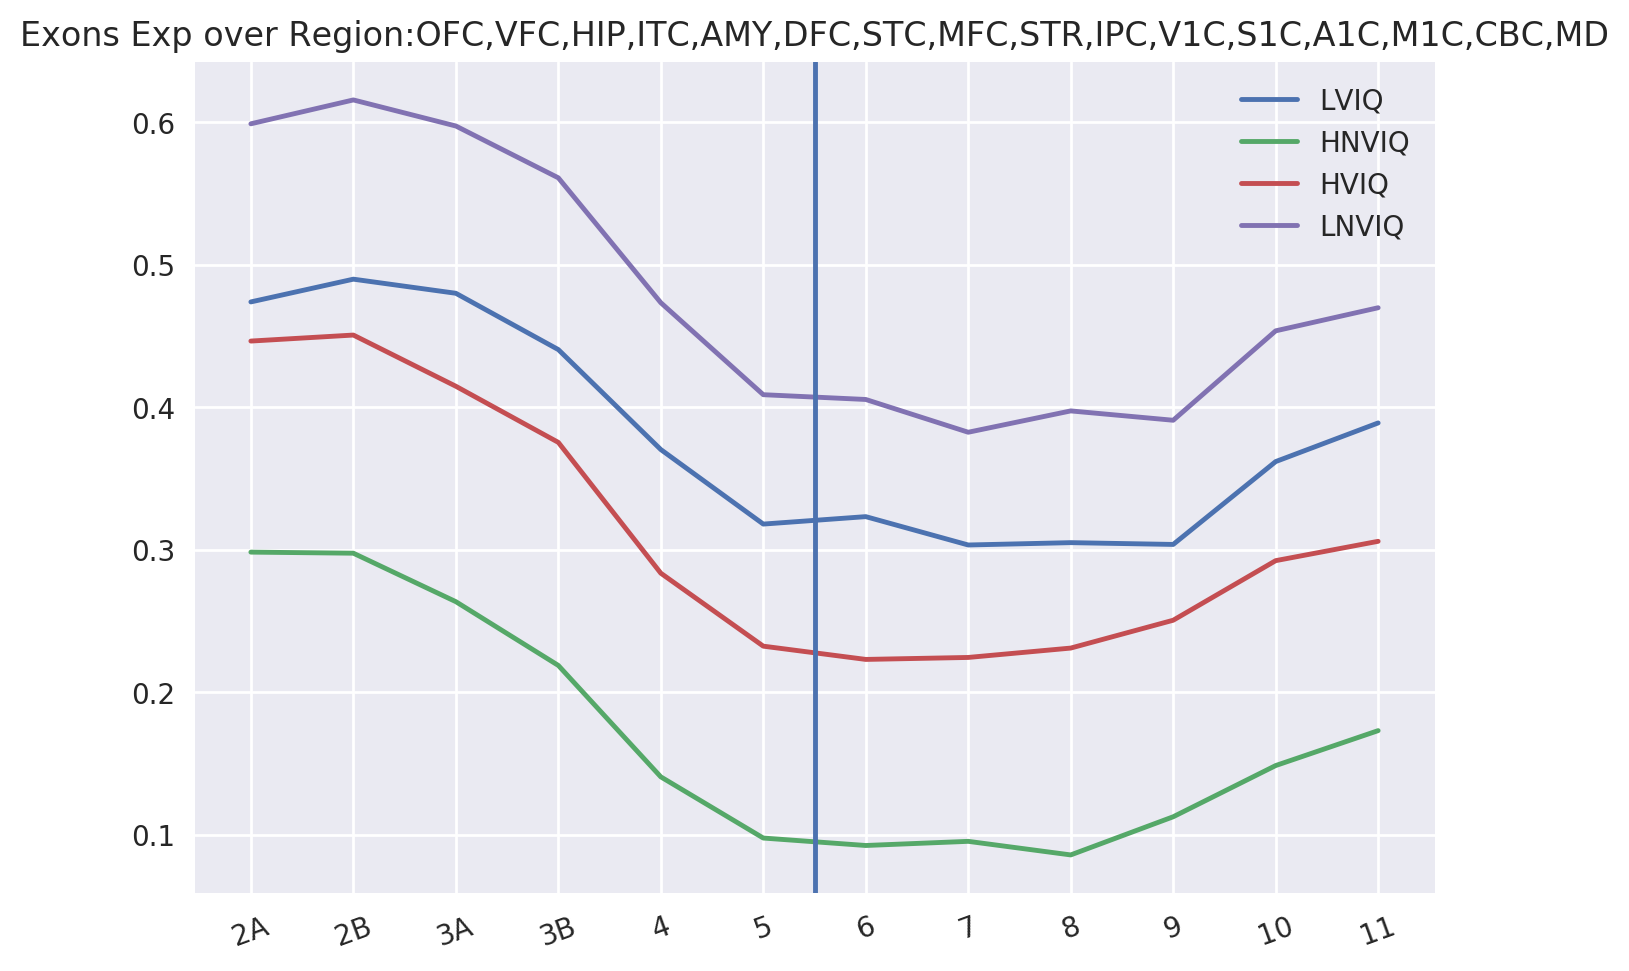

In [333]:
HVIQ_exons = list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["VIQ70"]>70]["row_num"])
LVIQ_exons = list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["VIQ70"]<70]["row_num"])
HNVIQ_exons = list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["NVIQ70"]>70]["row_num"])
LNVIQ_exons = list(bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["NVIQ70"]<70]["row_num"])
IQ = dict(zip(["HVIQ", "LVIQ", "HNVIQ", "LNVIQ"],[HVIQ_exons, LVIQ_exons, HNVIQ_exons, LNVIQ_exons]))
LookALLMutationTargetedExon2(IQ, Regionsgt20, bp_exon_row_meta, bp_exon_col_meta, NormExonExp)

# NonHitted Exons in Hitted Genes

chromatin
Loading records:151
psd
Loading records:81
channel
Loading records:36
sig_skel
Loading records:70


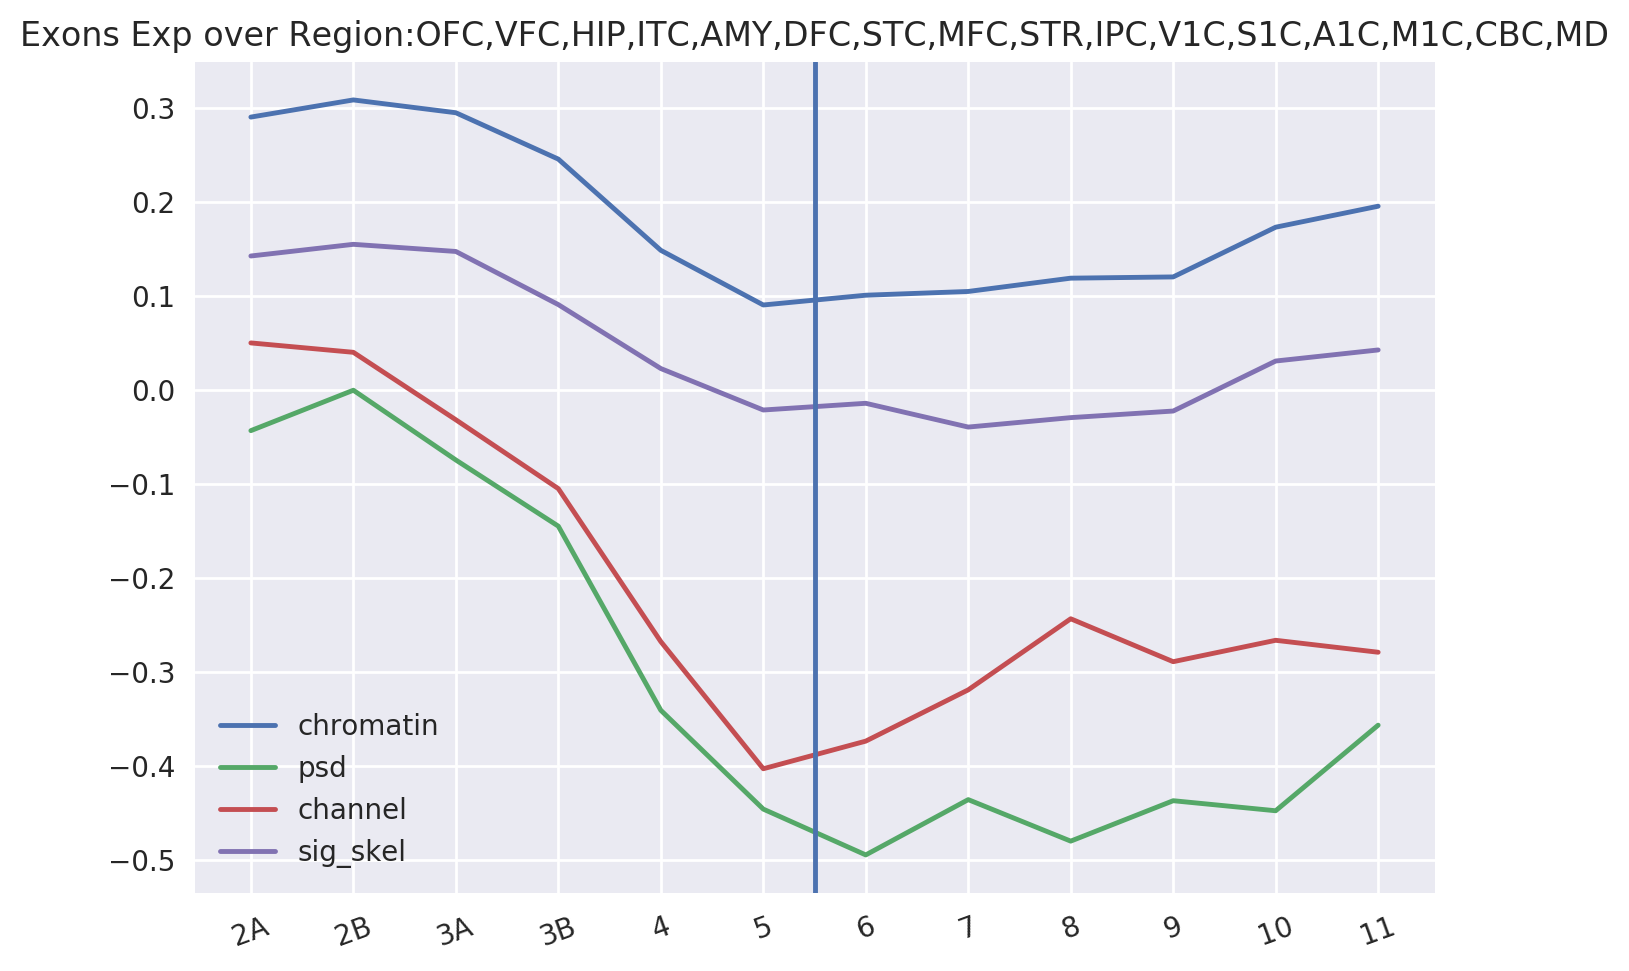

chromatin
Loading records:151
psd
Loading records:81
channel
Loading records:36
sig_skel
Loading records:70


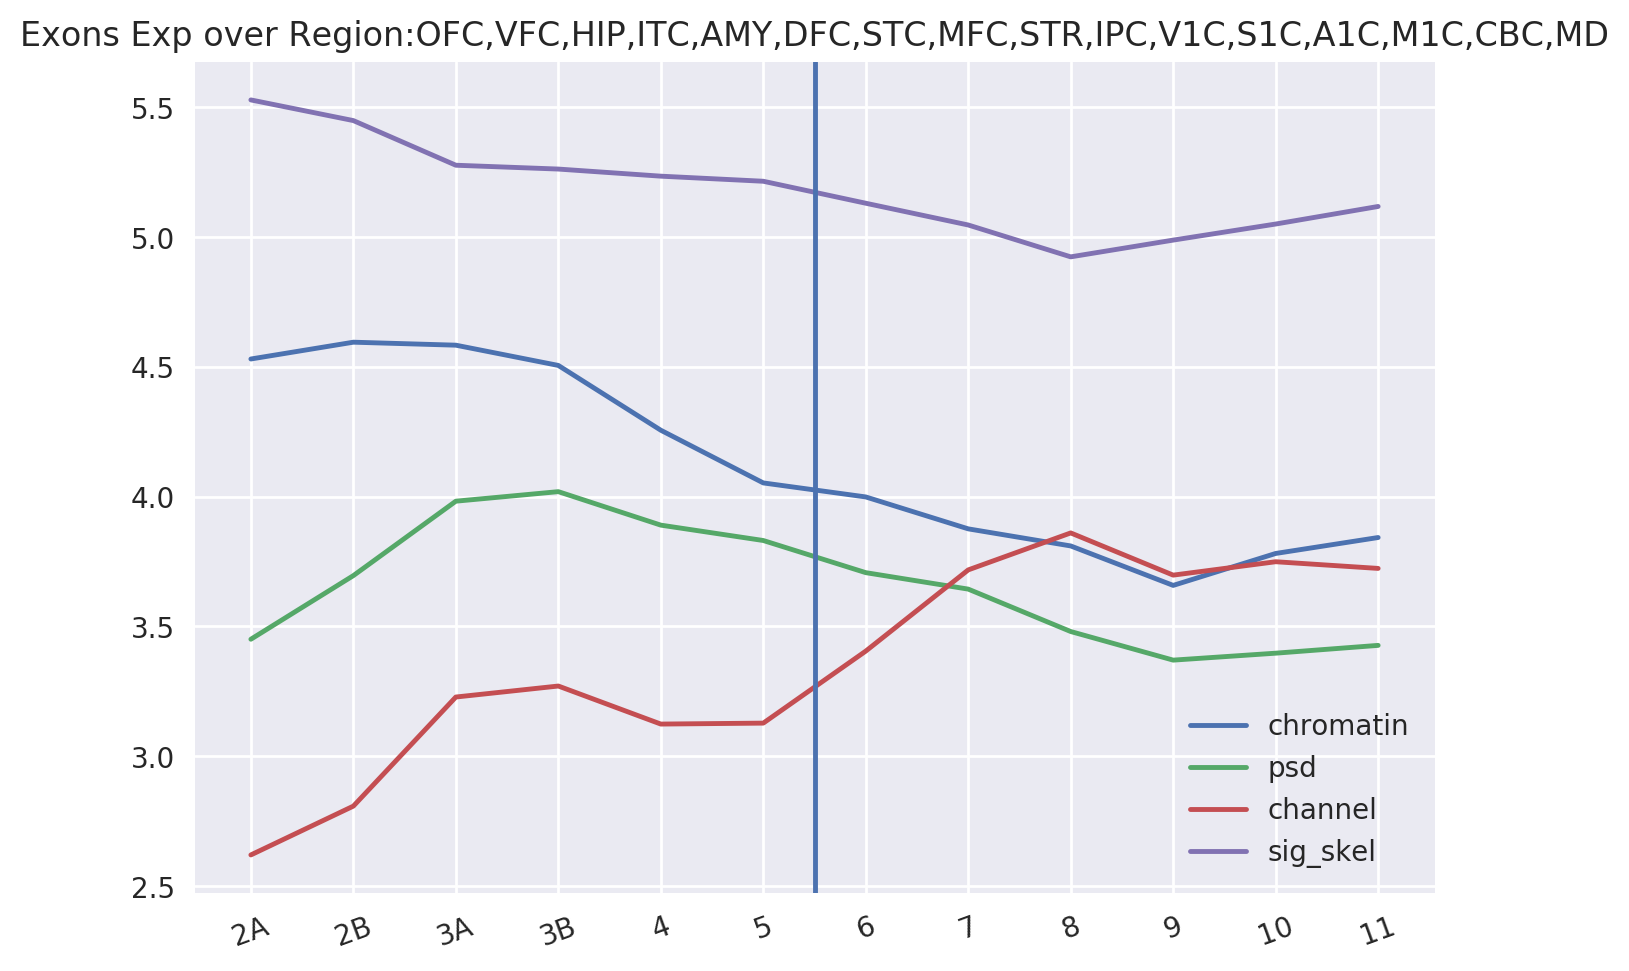

In [337]:
cates = {}
for func in ["chromatin", "channel", "sig_skel", "psd"]:
    cates[func] = list(bp_exon_row_meta_without_var[bp_exon_row_meta_without_var["Func"]==func]["row_num"])
LookALLMutationTargetedExon2(cates, Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, NormExonExp)
LookALLMutationTargetedExon2(cates, Regionsgt20, bp_exon_row_meta, 
                                      bp_exon_col_meta, ExonExp)

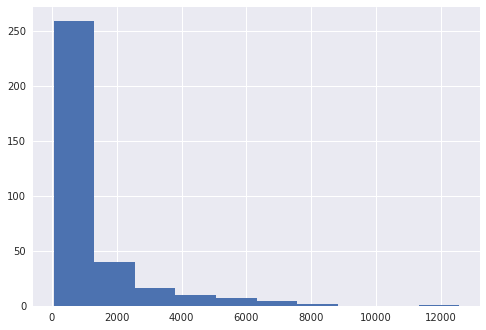

       row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id      start  \
1974      1975  1086984  ENSG00000006062     MAP3K14     9020.0   43340487   
5170      5171  1087175  ENSG00000012048       BRCA1      672.0   41196311   
8203      8204  1087365  ENSG00000032742       IFT88     8100.0   21205154   
11551    11552  1087537  ENSG00000049618      ARID1B    57492.0  157527300   
11693    11694  1087548  ENSG00000050344      NFE2L3     9603.0   26223679   

             end  exon length          Vars  
1974    43342167         1680  ;17:43342073  
5170    41197819         1508  ;17:41197776  
8203    21206278         1124  ;13:21205235  
11551  157530401         3101  ;6:157527665  
11693   26226745         3066   ;7:26224579  
      row_num  gene_id  ensembl_gene_id gene_symbol  entrez_id      start  \
1264     1265  1086943  ENSG00000005108      THSD7A   221981.0   11486856   
1279     1280  1086944  ENSG00000005156        LIG3     3980.0   33313006   
2902     2903  1087037  

In [278]:
plt.hist(lengths)
plt.show()
longexons = bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["exon length"]>=1000]
shortexons = bp_exon_row_meta_with_var[bp_exon_row_meta_with_var["exon length"]<1000]
print longexons.head()
print shortexons.head()

## Male Genes vs Female Genes /Exones

In [245]:
rec_lgd_entrez_id = [x.strip() for x in file("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler-rec-lgd.txt")]
print rec_lgd_entrez_id 
bs_GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/genes_microarray/rows_metadata.csv")
rec_lgd_gene_symbols = list(bs_GeneRow[bs_GeneRow["entrez_id"].isin(rec_lgd_entrez_id)]["gene_symbol"])
print len(rec_lgd_gene_symbols), rec_lgd_gene_symbols

['23126', '10765', '10716', '6326', '10787', '27086', '23001', '287', '22999', '57492', '64599', '55904', '5253', '51322', '6934', '2904', '23389', '57680', '1106', '29123', '23135', '83473', '23394', '1859', '1826', '23181', '23112']
26 ['SCN2A', 'NCKAP1', 'GRIN2B', 'DYRK1A', 'TNRC6B', 'ARID1B', 'MED13L', 'ANK2', 'POGZ', 'ANKRD11', 'DIP2A', 'FOXP1', 'RIMS1', 'GIGYF1', 'KDM6B', 'MLL5', 'DSCAM', 'KATNAL2', 'TCF7L2', 'WAC', 'ADNP', 'PHF2', 'WDFY3', 'CHD2', 'KDM5B', 'TBR1']


1
14
15


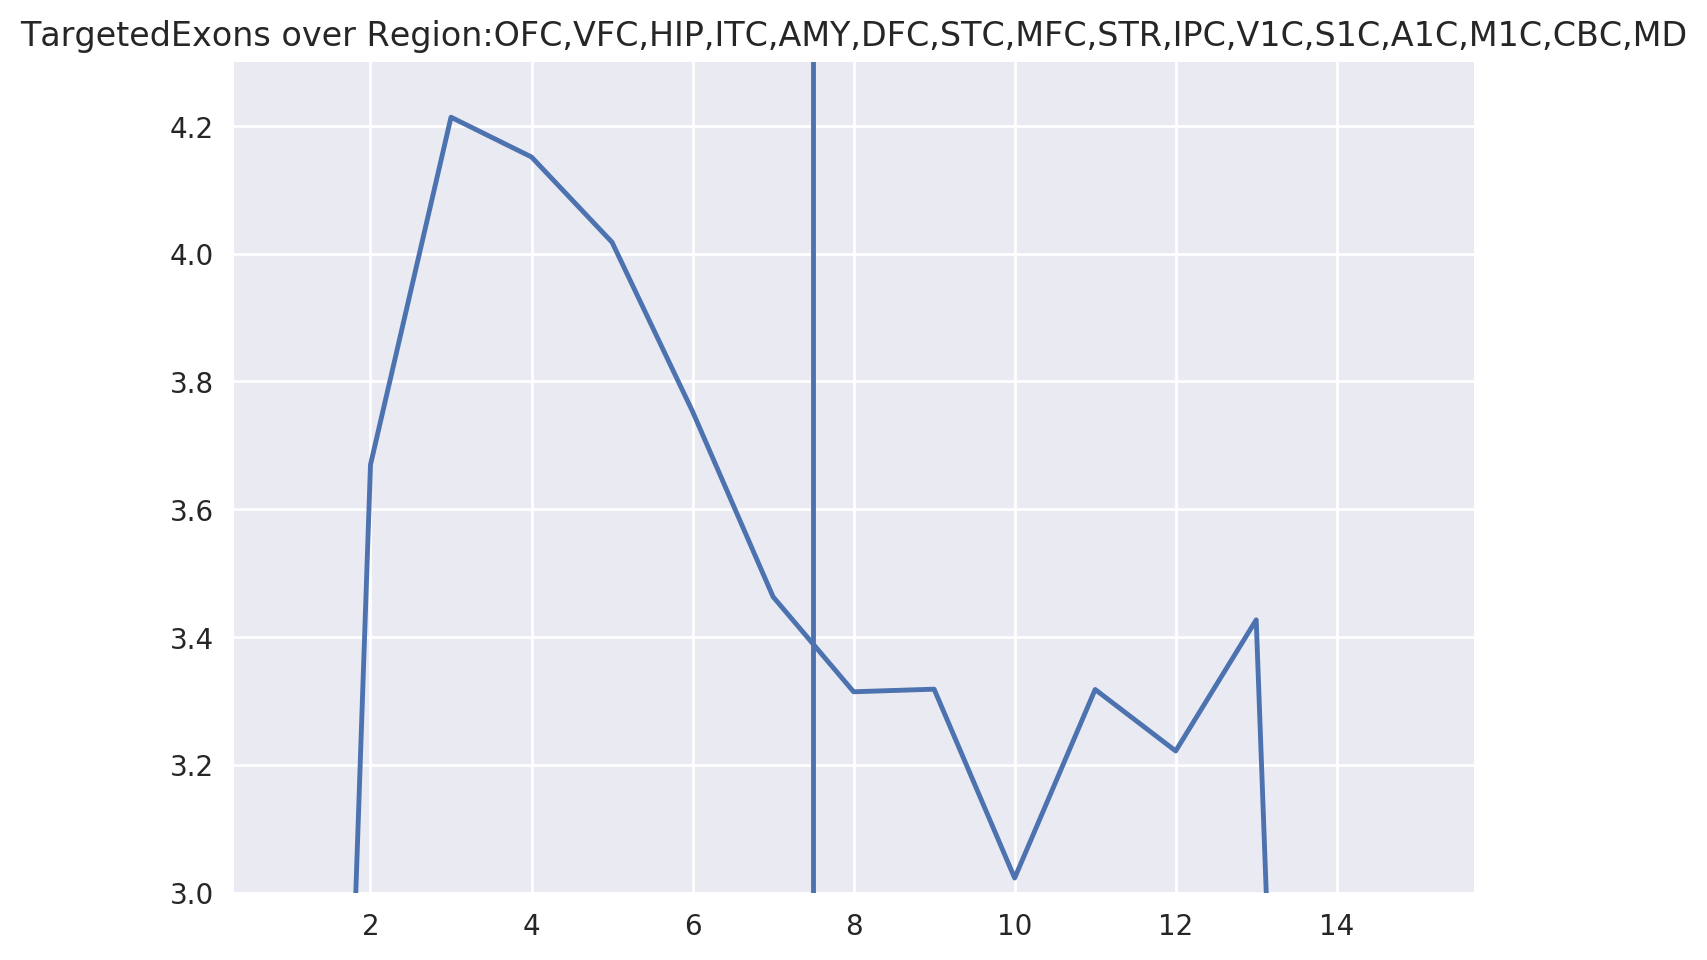

In [248]:
LookALLMutationTargetedGenes(rec_lgd_gene_symbols, Regionsgt20, GeneDat, ylim=(3,4.3), smooth=False)

Loading Genes 1003

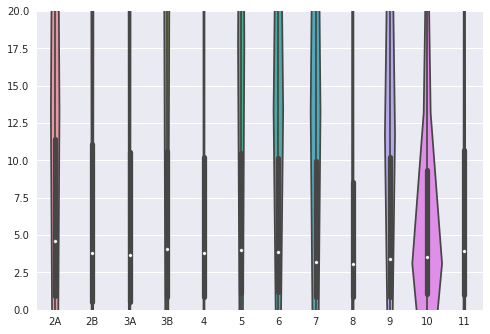

In [137]:
test_genes = GeneRow.head(1000)["gene_symbol"]
DisplayGeneSumExpViolin(test_genes, GeneDat, Regionsgt20)

In [ ]:
rec_lgd_entrez_id = [x.strip() for x in file("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler-rec-lgd.txt")]
print rec_lgd_entrez_id 
bs_GeneRow = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/genes_microarray/rows_metadata.csv")
rec_lgd_gene_symbols = list(bs_GeneRow[bs_GeneRow["entrez_id"].isin(rec_lgd_entrez_id)]["gene_symbol"])
print len(rec_lgd_gene_symbols), rec_lgd_gene_symbols